In [1]:
# some useful functions 
# some useful functions 
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import scipy.special as sc
from numba import cuda
from math import lgamma
from scipy import sparse
import time
import pandas as pd
import time
import seaborn as sns
from scipy.stats import mode

#########################################
# baseline class with type checking
########################################
class Baseline:
    def __init__(self, num_items, num_users, n_clusters_items=None, n_clusters_users=None,
                 prior_a=1, prior_b=1, seed = 42, user_clustering=None, item_clustering=None,
                 Y=None, X = None, theta = None, scheme_type = None, scheme_param = None,
                 sigma = None, bar_h_users=None, bar_h_items=None, gamma=None,
                 epsilon = 1e-6, verbose_users=False, verbose_items = False, device='cpu', 
                 cov_users=None, cov_items=None, alpha_c=1):

        #type checking
        if n_clusters_items is None:
            n_clusters_items = num_items
        if n_clusters_users is None:
            n_clusters_users = num_users

        if scheme_type is None:
            raise Exception('please provide scheme type')
        if scheme_type == 'DM':
            if not isinstance(bar_h_users, int) or (bar_h_users < 0) or (bar_h_users > num_users):
                raise Exception('provide valid maximum number of clusters users for DM)')
            if not isinstance(bar_h_items, int) or (bar_h_items < 0) or (bar_h_items>num_items):
                raise Exception('provide valid maximum number of clusters items for DM)')
            if not isinstance(sigma, (int, float)) or sigma >= 0:
                raise Exception('provide valid sigma (-item_clustering) parameter for DM')

        if scheme_type == 'DP':
            if not isinstance(scheme_param, (int, float)) or scheme_param <= 0:
                raise Exception('provide valid concentration parameter for DP')
        
        if scheme_type == 'PY':
            if not isinstance(sigma, (int, float)) or (sigma < 0 or sigma >= 1):
                raise Exception('provide valid sigma in [0, 1) for PY')
            if not isinstance(scheme_param, (int, float)) or scheme_param <= -sigma:
                raise Exception('provide valid user_clustering parameter for PY')
            if sigma == 0:
                print('note: for sigma=0 the PY reduces to DP, use scheme_type=DP for greater efficiency')
        if scheme_type == 'GN':
            if not isinstance(gamma, float) or (gamma<=0 or gamma>= 1):
                raise Exception('please provide valid gamma paramter for GN')

        if (X is not None) and (not isinstance(X, dict)):
            print('X should be a dict of the form covtype_number:matrix')

        self.seed = seed
        self.num_items = num_items
        self.num_users = num_users
        self.prior_a = prior_a
        self.prior_b = prior_b
        self.verbose_items = verbose_items
        self.verbose_users = verbose_users

        self.X = X
        self.epsilon = epsilon

        self.scheme_type = scheme_type
        self.scheme_param = scheme_param
        self.bar_h_users = bar_h_users
        self.bar_h_items = bar_h_items
        self.gamma = gamma
        self.sigma = sigma
        
        self.device = device
        self.alpha_c = alpha_c
        self.alpha_0 = np.sum(np.array(alpha_c))
        
        self.cov_names_users = None
        self.cov_types_users=None
        self.cov_nch_users=None
        self.cov_values_users = None
        self.cov_names_items=None
        self.cov_types_items=None
        self.cov_nch_items=None
        self.cov_values_items=None
        
        self.train_llk = None
        self.mcmc_draws_users = None
        self.mcmc_draws_items = None
        
        self.estimated_items = None
        self.estimated_users = None
        
        self.estimated_theta = None
        
        self.llk_edges = None
        
        self.waic = None
        
        if cov_users is not None:
            self.cov_names_users, self.cov_types_users, self.cov_values_users = self.process_cov(cov_users)
    
        if cov_items is not None:
            self.cov_names_items, self.cov_types_items, self.cov_values_items = self.process_cov(cov_items)
        
        if Y is None:
            print('randomly initialising data')
            self.generate_data(user_clustering=user_clustering, item_clustering=item_clustering, theta=theta)
        else:
            self.Y = Y
            self.theta = theta
            if user_clustering is None or item_clustering is None:
                self.init_cluster_det(user_clustering, item_clustering)           
            elif user_clustering == 'random' or item_clustering == 'random':
                self.init_cluster_random(user_clustering, item_clustering)
            else:
                self.process_clusters(user_clustering, item_clustering)
                
        if cov_users is not None:
            self.cov_nch_users = self.compute_nch(self.cov_values_users, self.user_clustering, self.n_clusters_users)
        if cov_items is not None:
            self.cov_nch_items = self.compute_nch(self.cov_values_items, self.item_clustering, self.n_clusters_items)
    
    def compute_mhk(self, user_clustering=None, item_clustering=None):
        if user_clustering is None:
            user_clustering = self.user_clustering
            num_users = self.num_users
            n_clusters_users = self.n_clusters_users
        else:
            num_users = len(self.user_clustering)
            n_clusters_users = len(np.unique(user_clustering))
            
        if item_clustering is None:
            item_clustering = self.item_clustering
            num_items = self.num_items
            n_clusters_items = self.n_clusters_items
        else:
            num_items = len(self.item_clustering)
            n_clusters_items = len(np.unique(item_clustering))
            
        user_clusters = sparse.csr_matrix(
            (np.ones(num_users),
            (range(num_users),
            user_clustering)),
            shape=(num_users, n_clusters_users))

        item_clusters = sparse.csr_matrix(
            (np.ones(num_items),
            (range(num_items),
            item_clustering)),
            shape=(num_items, n_clusters_items))

        mhk = user_clusters.T @ self.Y @ item_clusters
        return mhk
    
    def compute_yuk(self):
        item_clusters = sparse.csr_matrix(
            (np.ones(self.num_items),
            (range(self.num_items),
            self.item_clustering)),
            shape=(self.num_items, self.n_clusters_items))
        
        yuk = self.Y @ item_clusters
        return yuk
    
    def compute_yih(self):
        user_clusters = sparse.csr_matrix(
            (np.ones(self.num_users),
            (range(self.num_users),
            self.user_clustering)),
            shape=(self.num_users, self.n_clusters_users))

        yih = self.Y.T @ user_clusters
        return yih
    
    def process_cov(self, cov_list):
        cov_names = []
        cov_types = []
        cov_values = []
        for cov in cov_list:
            cov_name, cov_type = cov[0].split('_')
            cov_names.append(cov_name)
            cov_types.append(cov_type)
            cov_values.append(cov[1])             
        return cov_names, cov_types, cov_values
        
    def compute_nch(self, cov_values, clustering, n_clusters):
        cov_nch = []
        for cov in range(len(cov_values)):
            uniques = np.unique(cov_values[cov])
            nch = np.zeros((len(uniques), n_clusters))
            for h in range(n_clusters):
                mask = (clustering==h)
                for c in uniques:
                    nch[c, h] = (cov_values[cov][mask]==c).sum()    
            cov_nch.append(nch)
        return cov_nch
    
    def process_clusters(self, user_clustering, item_clustering):
        occupied_clusters_users, frequencies_users = np.unique(user_clustering, return_counts=True)
        self.frequencies_users = frequencies_users
        self.n_clusters_users = len(occupied_clusters_users)
        self.user_clustering = np.array(user_clustering)   
                    
        occupied_clusters_items, frequencies_items = np.unique(item_clustering, return_counts=True)
        self.frequencies_items = frequencies_items
        self.n_clusters_items = len(occupied_clusters_items)
        self.item_clustering = np.array(item_clustering)
        
    
    def init_cluster_det(self, user_clustering, item_clustering):       
        if user_clustering is None:
            if self.scheme_type == 'DM':
                print('using randomly initialised clusters for DM')
                user_clustering = [np.random.randint(self.bar_h_users) for _ in range(self.num_users)]
            else:
                user_clustering = [i for i in range(self.num_users)]
        if item_clustering is None:
            if self.scheme_type =='DM':
                print('randomly initiased item clusters under DM')
                item_clustering = [np.random.randint(self.bar_h_items) for _ in range(self.num_items)]
            else:
                item_clustering = [i for i in range(self.num_items)]
        
        occupied_clusters_users, frequencies_users = np.unique(user_clustering, return_counts=True)
        self.frequencies_users = frequencies_users
        self.n_clusters_users = len(occupied_clusters_users)
        self.user_clustering = np.array(user_clustering)   
                    
        occupied_clusters_items, frequencies_items = np.unique(item_clustering, return_counts=True)
        self.frequencies_items = frequencies_items
        self.n_clusters_items = len(occupied_clusters_items)
        self.item_clustering = np.array(item_clustering)
        return
    
    def generate_data(self, user_clustering=None, item_clustering=None, theta=None):
        np.random.seed(self.seed)
        if user_clustering == 'random' or item_clustering == 'random':
            self.init_cluster_random(user_clustering, item_clustering)
        elif user_clustering is None or item_clustering is None:
            self.init_cluster_det(user_clustering, item_clustering)
        else:
            self.process_clusters(user_clustering, item_clustering)
        
        if theta is None:
            theta = np.random.gamma(self.prior_a, self.prior_b, size=(self.n_clusters_users, self.n_clusters_items))
        
        self.theta = theta.copy()

        Y_params = theta[self.user_clustering][:, self.item_clustering]

        Y = np.random.poisson(Y_params)
        self.Y = Y.copy()
        return

    def init_cluster_random(self, user_clustering=None, item_clustering=None):
        np.random.seed(self.seed)
        user_clustering = [0]
        H = 1
        V = 1
        users_frequencies = [1]
        print('initialsing user clusters random')
        nch_users = None
        if self.cov_values_users is not None:
            nch_users = []
            for cov in range(len(self.cov_values_users)):
                n_unique = len(np.unique(self.cov_values_users[cov]))
                temp = np.zeros(n_unique)
                c = self.cov_values_users[cov][0]
                temp[c] += 1
                nch_users.append(temp.reshape(-1, 1))
                
        for u in range(1, self.num_users):
            # order should be guaranteed by properties of dict in pyhton
            probs = sampling_scheme(V, H, users_frequencies, bar_h=self.bar_h_users, scheme_type=self.scheme_type,
                                    scheme_param=self.scheme_param, sigma=self.sigma, gamma=self.gamma)
            log_probs_cov = 0
            if nch_users is not None:
                log_probs_cov = compute_log_probs_cov(probs, u, self.cov_types_users, nch_users, self.cov_values_users, 
                                                  users_frequencies, self.alpha_c, self.alpha_0)
            
            # convert back using exp and normalise
            log_probs = np.log(probs+self.epsilon)+log_probs_cov
            probs = np.exp(log_probs-max(log_probs))
            probs /= probs.sum()
            
            assignment = np.random.choice(len(probs), p=probs)
            if assignment >= H:
                H += 1
                users_frequencies.append(1)
                
                if nch_users is not None:
                    for cov in range(len(self.cov_values_users)):
                        n_unique = len(np.unique(self.cov_values_users[cov]))
                        temp = np.zeros(n_unique)
                        c = self.cov_values_users[cov][u]
                        temp[c] += 1
                        nch_users[cov] = np.column_stack([nch_users[cov], temp.reshape(-1, 1)])
            else:
                users_frequencies[assignment] += 1
                if nch_users is not None:
                    for cov in range(len(self.cov_values_users)):
                        c = self.cov_values_users[cov][u]
                        nch_users[cov][c, assignment] += 1
                        
            user_clustering.append(assignment)
            V += 1

        self.n_clusters_users = H
        self.frequencies_users = users_frequencies

        item_clustering = [0]
        K = 1
        V = 1
        items_frequencies = [1]
        print('initialising item clusters random')
        nch_items = None
        if self.cov_values_items is not None:
            nch_items = []
            for cov in range(len(self.cov_values_items)):
                n_unique = len(np.unique(self.cov_values_items[cov]))
                temp = np.zeros(n_unique)
                c = self.cov_values_items[cov][0]
                temp[c] += 1
                nch_items.append(temp.reshape(-1, 1))
                
        for i in range(1, self.num_items):
            probs = sampling_scheme(V, K, items_frequencies, bar_h=self.bar_h_items, scheme_type=self.scheme_type,
                                    scheme_param=self.scheme_param, sigma=self.sigma, gamma=self.gamma)
            log_probs_cov = 0
            if nch_items is not None:
                log_probs_cov = compute_log_probs_cov(probs, i, self.cov_types_items, nch_items, self.cov_values_items, 
                                                  items_frequencies, self.alpha_c, self.alpha_0)
            
            log_probs = np.log(probs+self.epsilon)+log_probs_cov
            probs = np.exp(log_probs-max(log_probs))
            probs /= probs.sum()
                        
            assignment = np.random.choice(len(probs), p=probs)
            if assignment >= K:
                K += 1
                items_frequencies.append(1)
                
                if nch_items is not None:
                    for cov in range(len(self.cov_values_items)):
                        n_unique = len(np.unique(self.cov_values_items[cov]))
                        temp = np.zeros(n_unique)
                        c = self.cov_values_items[cov][i]
                        temp[c] += 1
                        nch_items[cov] = np.column_stack([nch_items[cov], temp.reshape(-1, 1)])
            else:
                items_frequencies[assignment] += 1
                if nch_items is not None:
                    for cov in range(len(self.cov_values_items)):
                        c = self.cov_values_items[cov][i]
                        nch_items[cov][c, assignment] += 1
                        
            item_clustering.append(assignment)
            V += 1
            
        self.n_clusters_items = K
        self.frequencies_items = items_frequencies

        self.user_clustering = np.array(user_clustering)    
        self.n_clusters_users = len(np.unique(user_clustering))

        # item quantities
        self.item_clustering = np.array(item_clustering)
        self.n_clusters_items = len(np.unique(item_clustering))
        
        return user_clustering, item_clustering
    
    def gibbs_step(self):
        # do nothing for baseline
        pass
    
    def gibbs_train(self, n_iters, verbose=0, warm_start=False):
        np.random.seed(self.seed)
        
        self.n_iters = n_iters
        
        ll = compute_log_likelihood(nh = self.frequencies_users, nk = self.frequencies_items, a = self.prior_a, 
                                         b = self.prior_b, eps = self.epsilon, mhk=self.compute_mhk(), 
                                         user_clustering=self.user_clustering, 
                                        item_clustering=self.item_clustering,
                                        dg_u=np.zeros(self.num_users), 
                                        dg_i=np.zeros(self.num_items), 
                                        dg_cl_i=np.zeros(self.n_clusters_items), 
                                        dg_cl_u=np.zeros(self.n_clusters_users),
                                        degree_corrected=False)
        
        print('starting log likelihood', ll)
        
    
        llks = np.zeros(n_iters+1)
        user_cluster_list = np.zeros((n_iters+1, self.num_users), dtype=np.int32)
        item_cluster_list = np.zeros((n_iters+1, self.num_items), dtype=np.int32)
        frequencies_users_list = []
        frequencies_items_list = []
        
        llks[0] = ll
        user_cluster_list[0] = self.user_clustering.copy()
        item_cluster_list[0] = self.item_clustering.copy()
        frequencies_users_list.append(self.frequencies_users.copy())
        frequencies_items_list.append(self.frequencies_items.copy())
        
        for it in range(n_iters):
            
            self.gibbs_step()
            ll = compute_log_likelihood(nh = self.frequencies_users, 
                                        nk = self.frequencies_items,
                                        a = self.prior_a, 
                                        b = self.prior_b, 
                                        eps = self.epsilon,
                                        mhk = self.compute_mhk(),
                                        user_clustering=self.user_clustering, 
                                        item_clustering=self.item_clustering,
                                        dg_u=np.zeros(self.num_users), 
                                        dg_i=np.zeros(self.num_items), 
                                        dg_cl_i=np.zeros(self.n_clusters_items), 
                                        dg_cl_u=np.zeros(self.n_clusters_users), 
                                        degree_corrected=False)
            llks[it+1] += ll
            user_cluster_list[it+1] += self.user_clustering
            item_cluster_list[it+1] += self.item_clustering
            frequencies_users_list.append(self.frequencies_users.copy())
            frequencies_items_list.append(self.frequencies_items.copy())
            
            if verbose >= 1:
                if it % (n_iters // 10) == 0:
                    print(it, llks[it+1])
                if verbose >= 2:
                    print('user freq ', self.frequencies_users)
                    print('ite freq ', self.frequencies_items)
                    if verbose >= 3:
                        print('user cluser ', self.user_clustering)
                        print('item cluster ', self.item_clustering)
        
        print('end llk: ', llks[-1])
        if warm_start is True:
            self.train_llk = np.concatenate([self.train_llk, llks])
            self.mcmc_draws_users = np.concatenate((self.mcmc_draws_users, user_cluster_list))
            self.mcmc_draws_items = np.concatenate((self.mcmc_draws_items, item_cluster_list))
            self.mcmc_draws_users_frequencies = np.concatenate((self.mcmc_draws_users_frequencies, frequencies_users_list))
            self.mcmc_draws_items_frequencies = np.concatenate((self.mcmc_draws_items_frequencies, frequencies_items_list))
        else:
            self.train_llk = llks
            self.mcmc_draws_users = user_cluster_list
            self.mcmc_draws_items = item_cluster_list
            self.mcmc_draws_users_frequencies = frequencies_users_list
            self.mcmc_draws_items_frequencies = frequencies_items_list
            
        return llks, user_cluster_list, item_cluster_list
    
    def estimate_cluster_assignment_mode(self, burn_in = 0, thinning = 1):
        if self.mcmc_draws_users is None:
            raise Exception('model must be trained first')
        
        assignment_users = -np.ones(self.num_users, dtype=np.int64)
        for u in range(self.num_users):
            assignment_users[u] = int(mode(self.mcmc_draws_users[burn_in::thinning, u])[0])
        
        assignment_items = -np.ones(self.num_items, dtype=np.int64)
        for i in range(self.num_items):
            assignment_items[i] = int(mode(self.mcmc_draws_items[burn_in::thinning, i])[0])
        
        self.user_clustering[:] = assignment_users
        _, frequencies_users = np.unique(assignment_users, return_counts=True)
        self.frequencies_users = frequencies_users
        
        self.item_clustering[:] = assignment_items
        _, frequencies_items = np.unique(assignment_items, return_counts=True)
        self.frequencies_items = frequencies_items
        
        self.estimated_items = 'mode'
        self.estimated_users = 'mode'
        
        return assignment_users, assignment_items
    
    def estimate_cluster_assignment_vi(self, method='avg', max_k=None, burn_in=0, thinning=1):
        if method not in ['avg', 'comp', 'all']:
            raise Exception('invalid method')
        
        cc_users, cc_items = self.compute_co_clustering_matrix(burn_in=burn_in, thinning=thinning)
        
        psm_users = cc_users/np.max(cc_users)
        psm_items = cc_items/np.max(cc_items)

        res_users = minVI(psm_users, cls_draw = self.mcmc_draws_users[burn_in::thinning], method=method, max_k=max_k)
        res_items = minVI(psm_items, cls_draw = self.mcmc_draws_items[burn_in::thinning], method=method, max_k=max_k)
        
        est_cluster_users = res_users['cl']
        est_cluster_items = res_items['cl']
        
        vi_value_users = res_users['value']
        vi_value_items = res_items['value']
        
        self.user_clustering[:] = est_cluster_users
        unique_users, frequencies_users = np.unique(est_cluster_users, return_counts=True)
        self.frequencies_users = frequencies_users
        self.n_clusters_users = len(unique_users)
        
        self.item_clustering[:] = est_cluster_items
        unique_items, frequencies_items = np.unique(est_cluster_items, return_counts=True)
        self.frequencies_items = frequencies_items
        self.n_clusters_items = len(unique_items)
        
        self.estimated_items = 'vi'
        self.estimated_users = 'vi'
                
        return est_cluster_users, est_cluster_items, vi_value_users, vi_value_items
    
    def compute_co_clustering_matrix(self, burn_in=0, thinning=1):
        if self.mcmc_draws_users is None:
            raise Exception('model must be trained first')
        
        cc_users = compute_co_clustering_matrix(self.mcmc_draws_users[burn_in::thinning])
        self.co_clustering_users = cc_users
        
        cc_items = compute_co_clustering_matrix(self.mcmc_draws_items[burn_in::thinning])
        self.co_clustering_items = cc_items
        
        return cc_users, cc_items
    
    def compute_llk(self, iter):
        np.random.seed(self.seed)
        
        clustering_users = self.mcmc_draws_users[iter]
        clustering_items = self.mcmc_draws_items[iter]
        frequencies_users = self.mcmc_draws_users_frequencies[iter]
        frequencies_items = self.mcmc_draws_items_frequencies[iter]
        
        mhk = self.compute_mhk(clustering_users, clustering_items)
        # first sample theta
        theta = np.random.gamma(self.prior_a+mhk, 
                                1/(self.prior_b+np.outer(frequencies_users, frequencies_items)))
        
        # log likelihood
        llk_out = []
        for u in range(self.num_users):
            for i in range(self.num_items):
                zu = clustering_users[u]
                qi = clustering_items[i]
                llk_out.append(self.Y[u,i]*np.log(theta[zu, qi])-theta[zu,qi])
        return llk_out
    
    def point_predict(self, pairs, seed=None):
        if seed is None:
            np.random.seed(self.seed)
        elif seed == -1:
            pass
        else:
            np.random.seed(seed)
        
        uniques_ratings, frequencies_ratings = np.unique(self.Y, return_counts=True)
        
        preds = []
        for u, i in pairs:
            # predict with predictive posterior mean
            preds.append(np.random.choice(uniques_ratings, p=frequencies_ratings/np.sum(frequencies_ratings)))

        return preds
    
    def predict_with_ranking(self, users):        
        top_cluster =[]
        for u in users:
            num = np.random.randint(1, self.num_items)
            choice = np.random.choice(self.num_items, num, replace=False)
            top_cluster.append(choice)

        return top_cluster
    
    def predict_k(self, users, k):        
        out = []
        for u in users:
            choice = np.random.choice(self.num_items, k, replace=False)
            out.append(choice)

        return out

#########################
# ESBM
#######################
class esbm(Baseline):
    def __init__(self, num_items, num_users, n_clusters_items=None, n_clusters_users=None,
                 prior_a=1, prior_b=1, seed = 42, user_clustering=None, item_clustering=None,
                 Y=None, X = None, theta = None, scheme_type = None, scheme_param = None,
                 sigma = None, bar_h_users=None, bar_h_items=None, gamma=None,
                 epsilon = 1e-6, verbose_users=False, verbose_items = False, device='cpu', 
                 cov_users=None, cov_items=None, alpha_c=1):

        super().__init__(num_items=num_items, num_users=num_users, n_clusters_items=n_clusters_items, n_clusters_users=n_clusters_users,
                 prior_a=prior_a, prior_b=prior_b, seed = seed, user_clustering=user_clustering, item_clustering=item_clustering,
                 Y=Y, X = X, theta = theta, scheme_type = scheme_type, scheme_param = scheme_param, sigma = sigma, bar_h_users=bar_h_users,
                 bar_h_items=bar_h_items, gamma=gamma, epsilon = epsilon, verbose_items=verbose_items, verbose_users=verbose_users,
                 device=device, alpha_c=alpha_c, cov_users=cov_users, cov_items=cov_items)
            
    def gibbs_step(self):
        frequencies_users = self.frequencies_users
        frequencies_items = self.frequencies_items         
        
        #################################################
        # step for users
        #################################################

        mhk = self.compute_mhk()
        yuk = self.compute_yuk()

        H = self.n_clusters_users
        V = self.num_users

        order_users = np.arange(self.num_users)
        #np.random.shuffle(order_users)
        
        nch = self.cov_nch_users
        
        for u in order_users:
            if self.verbose_users is True:
                print('\n', self.user_clustering, u)
                print('H ', H)
                print('frequencies', frequencies_users)
                print('nch', nch)
            
            start = time.time()
            cluster_user = self.user_clustering[u]
            frequencies_users_minus = frequencies_users.copy()

            frequencies_users_minus[cluster_user] -= 1
            frequencies_users[cluster_user] -= 1
            
            if nch is not None:
                nch_minus = []
                for cov in range(len(nch)):
                    c = self.cov_values_users[cov][u]
                    nch_minus.append(nch[cov].copy())
                    nch_minus[-1][c, cluster_user] -= 1
            
            # if the current cluster becomes empty, remove that row
            if frequencies_users_minus[cluster_user] == 0:
                mhk_minus = np.vstack([mhk[:cluster_user], mhk[cluster_user+1:]])
                frequencies_users_minus = np.concatenate([frequencies_users_minus[:cluster_user], frequencies_users_minus[cluster_user+1:]])
                H -= 1
                if nch is not None:
                    for cov in range(len(nch)):
                        nch_minus[cov] = np.hstack([nch[cov][:, :cluster_user], nch[cov][:, cluster_user+1:]])
            else:
                mhk_minus = mhk.copy()
                mhk_minus[cluster_user] -= yuk[u]
            
            # print('starting time', time.time()-start)
            
            start_prior = time.time()

            probs = sampling_scheme(V, H, frequencies=frequencies_users_minus, bar_h=self.bar_h_users, scheme_type=self.scheme_type, 
                                    scheme_param=self.scheme_param, sigma=self.sigma, gamma=self.gamma)

            start_log_probs = time.time()
            
            log_probs = compute_prob(probs, mhk_minus=mhk_minus, frequencies_primary_minus=frequencies_users_minus, frequencies_secondary=frequencies_items,
                                     y_values=np.ascontiguousarray(yuk[u]), epsilon=self.epsilon, a=self.prior_a, b=self.prior_b, max_clusters=H, 
                                     is_user_mode=True, degree_corrected=False, degree_param=1, degree_cluster_minus=[1], degree_node=1, device=self.device)
            
            # uses old function
            # log_probs = compute_prob_users(probs, mhk_minus = mhk_minus, frequencies_users_minus=frequencies_users_minus, 
            #                             frequencies_items=frequencies_items, yuk_u = np.ascontiguousarray(yuk[u]), H=H, 
            #                             epsilon=self.epsilon, a = self.prior_a, b=self.prior_b,  device=self.device,
            #                             degree_corrected=False, degree_cluster=[1], degree_node=1)
            
            # print(log_probs)
            start_cov = time.time()
            log_probs_cov = 0
            if nch is not None:
                log_probs_cov = compute_log_probs_cov(probs, idx=u, cov_types=self.cov_types_users, cov_nch = nch_minus, cov_values = self.cov_values_users, 
                                                nh=frequencies_users_minus, alpha_c = self.alpha_c, alpha_0 = self.alpha_0)
            
            probs = np.log(probs+self.epsilon)+log_probs + log_probs_cov
            probs = np.exp(probs-max(probs))
            probs /= probs.sum()
            # print(u, ' probs ', probs)
            # choose cluster assignment
            # print('prob compute time', time.time()-start_prior)
            
            start_assignment = time.time()
            assignment = np.random.choice(len(probs), p=probs)
            
            if self.verbose_users is True:
                print('assignment', assignment)
            # if assignment is the same do nothing
            if assignment == cluster_user:
                if frequencies_users[cluster_user] == 0:
                    H += 1
                frequencies_users[cluster_user] += 1
                if self.verbose_users is True:
                    print('same cluster, do nothing')
            else:
                # new cluster
                if frequencies_users[cluster_user]==0:
                    self.user_clustering[np.where(self.user_clustering>= cluster_user)] -= 1

                if assignment >= H:
                    if self.verbose_users is True:
                        print('assigning to new cluster: ', assignment)
                        print('old cluster: ', cluster_user)
                    self.user_clustering[u] = assignment

                    #updating quantities
                    H += 1
                    frequencies_users_minus = np.append(frequencies_users_minus, 1)

                    # updating mhk (yuk not changed since item clusters unchanged)
                    mhk = np.vstack([mhk_minus, yuk[u]])
                    
                    #update nch
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_users[cov][u]
                            nch_minus[cov] = np.column_stack([nch_minus[cov], np.zeros(nch_minus[cov].shape[0])])
                            nch_minus[cov][c, assignment] += 1
                            
                        nch = nch_minus
                # into old cluster
                else:
                    if self.verbose_users is True:
                        print('adding to old: ', assignment)
                    frequencies_users_minus[assignment] += 1
                    self.user_clustering[u] = assignment
                    mhk_minus[assignment] += yuk[u]
                    mhk = mhk_minus
                    
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_users[cov][u]
                            nch_minus[cov][c, assignment] += 1
                        nch = nch_minus
                frequencies_users = frequencies_users_minus
            # print('assignment time ', time.time()-start_assignment, '\n')
        
        self.cov_nch_users = nch
        self.n_clusters_users = H
        self.frequencies_users = frequencies_users

        ################################################
        # step for items
        ################################################
        K = self.n_clusters_items
        V = self.num_items

        yih = self.compute_yih()
        mhk = self.compute_mhk()

        order_items = np.arange(self.num_items)
        #np.random.shuffle(order_items)
        
        nch = self.cov_nch_items

        for i in order_items:
            if self.verbose_items is True:
                print('\n', self.item_clustering, i)
                print('frequencies', frequencies_items)
                print('K ', K)
                #print(mhk)
            
            cluster_item = self.item_clustering[i]
            frequencies_items_minus = frequencies_items.copy()

            frequencies_items_minus[cluster_item] -= 1
            frequencies_items[cluster_item] -= 1
            
            if nch is not None:
                nch_minus = []
                for cov in range(len(nch)):
                    c = self.cov_values_items[cov][i]
                    nch_minus.append(nch[cov].copy())
                    nch_minus[-1][c, cluster_item] -= 1

            if frequencies_items_minus[cluster_item]==0:
                mhk_minus = np.hstack([mhk[:, :cluster_item],mhk[:, cluster_item+1:]])
                frequencies_items_minus = np.concatenate([frequencies_items_minus[:cluster_item], frequencies_items_minus[cluster_item+1:]])
                K -= 1
                if nch is not None:
                    for cov in range(len(nch)):
                        nch_minus[cov] = np.hstack([nch[cov][:, :cluster_item], nch[cov][:, cluster_item+1:]])
            else:
                mhk_minus = mhk.copy()
                mhk_minus[:, cluster_item] -= yih[i]

            probs = sampling_scheme(V, K, frequencies=frequencies_items_minus, bar_h=self.bar_h_items, scheme_type=self.scheme_type, scheme_param=self.scheme_param, sigma=self.sigma, gamma=self.gamma)
            
            # uses old function
            # log_probs = compute_prob_items(probs=probs, mhk_minus=mhk_minus, frequencies_items_minus=frequencies_items_minus, frequencies_users = frequencies_users,
            #                             yih_i=np.ascontiguousarray(yih[i]), a=self.prior_a, b=self.prior_b, epsilon=self.epsilon, K=K, device=self.device,
            #                             degree_corrected=False, degree_cluster=[1], degree_node=1)
            
            log_probs = compute_prob(probs, mhk_minus=mhk_minus, frequencies_primary_minus=frequencies_items_minus, frequencies_secondary=frequencies_users,
                                     y_values=np.ascontiguousarray(yih[i]), epsilon=self.epsilon, a=self.prior_a, b=self.prior_b, max_clusters=K, 
                                     is_user_mode=False, degree_corrected=False, degree_param=1, degree_cluster_minus=[1], degree_node=1, device=self.device)
            
            
            log_probs_cov = 0
            if nch is not None:
                log_probs_cov = compute_log_probs_cov(probs, idx=i, cov_types=self.cov_types_items, cov_nch = nch_minus, cov_values = self.cov_values_items, 
                                                nh=frequencies_items_minus, alpha_c = self.alpha_c, alpha_0 = self.alpha_0)
                                
            probs = np.log(probs+self.epsilon)+log_probs+log_probs_cov
            probs = np.exp(probs-max(probs))
            probs /= probs.sum()
            # print(i, 'probs', probs)

            # choose cluster assignment
            assignment = np.random.choice(len(probs), p=probs)
            # if assignment is the same do nothing
            if assignment == cluster_item:
                if frequencies_items[cluster_item]==0:
                    K += 1
                frequencies_items[cluster_item] += 1
                if self.verbose_items is True:
                    print('adding to the same, do nothing')

            else:
                if frequencies_items[cluster_item]==0:
                    self.item_clustering[np.where(self.item_clustering>= cluster_item)] -= 1

                if assignment >= K:
                    if self.verbose_items is True:
                        print("assigning to new cluster: ", assignment)
                        print('old cluster: ', cluster_item)

                    self.item_clustering[i] = assignment

                    K += 1
                    frequencies_items_minus = np.append(frequencies_items_minus, 1)

                    # updating mhk (yuk not changed since item clusters unchanged)
                    mhk = np.column_stack([mhk_minus, yih[i]])
                    
                    #update nch
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_items[cov][i]
                            nch_minus[cov] = np.column_stack([nch_minus[cov], np.zeros(nch_minus[cov].shape[0])])
                            nch_minus[cov][c, assignment] += 1
                            
                        nch = nch_minus

                else:
                    if self.verbose_items is True:
                        print('adding to old: ', assignment)

                    frequencies_items_minus[assignment] += 1
                    self.item_clustering[i] = assignment

                    # previous connections already removed, add the new ones
                    mhk_minus[:, assignment] += yih[i]
                    mhk = mhk_minus
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_items[cov][i]
                            nch_minus[cov][c, assignment] += 1
                        nch = nch_minus
                        
                frequencies_items = frequencies_items_minus
        self.cov_nch_items = nch
        self.n_clusters_items = K
        self.frequencies_items = frequencies_items
        
        return
    
    def estimate_theta(self):
        if self.estimated_users is None or self.estimated_items is None:
            raise Exception('cluster assignment must be estimated first')
        
        mhk = self.compute_mhk(self.user_clustering, self.item_clustering)
        theta = (self.prior_a + mhk) / (self.prior_b + np.outer(self.frequencies_users, self.frequencies_items))
        
        self.estimated_theta = theta
        return theta
    
    def point_predict(self, pairs, seed=None):
        if seed is None:
            np.random.seed(self.seed)
        elif seed == -1:
            pass
        else:
            np.random.seed(seed)
        
        if self.estimated_users is None or self.estimated_items is None:
            raise Exception('cluster assignment must be estimated first')
        if self.estimated_theta is None:
            self.estimate_theta()
        
        if not isinstance(pairs, list):
            pairs = [pairs]
        
        preds = []
        for u, i in pairs:
            zu = self.user_clustering[u]
            qi = self.item_clustering[i]
            
            # predict with predictive posterior mean
            preds.append(self.estimated_theta[zu, qi])

        return preds
    
    def predict_with_ranking(self, users):
        if self.estimated_users is None or self.estimated_items is None:
            raise Exception('cluster assignment must be estimated first')
        
        if self.estimated_theta is None:
            self.estimate_theta()
        
        theta = self.estimated_theta
        
        out = []
        for u in users:
            zu = self.user_clustering[u]
            preds = theta[zu]
            top_cluster = np.argsort(preds)[::-1][0]
            top_items = np.arange(self.num_items)[np.where(self.item_clustering==top_cluster)]
            unseen_items = np.where(self.Y[u] == 0)[0]
            unseen_items_intersect = np.intersect1d(top_items, unseen_items)
            out.append(unseen_items_intersect)
        
        self.predict_mode = 'ranking'
        return out
    
    def predict_k(self, users, k=10, mode='random', seed=42):
        np.random.seed(seed)
        if self.estimated_users is None or self.estimated_items is None:
            raise Exception('cluster assignment must be estimated first')
        
        if self.estimated_theta is None:
            self.estimate_theta()
        
        if mode == 'popularity':
            degree_items = self.Y.sum(axis=0)
            
        theta = self.estimated_theta
        out = []
        for u in users:
            zu = self.user_clustering[u]
            preds = theta[zu]
            top_cluster = np.argsort(preds)[::-1][0]
            top_items = np.arange(self.num_items)[np.where(self.item_clustering==top_cluster)]
            unseen_items = np.where(self.Y[u] == 0)[0]
            unseen_items_intersect = np.intersect1d(top_items, unseen_items)
            i = 1
            while len(unseen_items_intersect) < k:
                top_cluster = np.argsort(preds)[::-1][i]
                top_items = np.arange(self.num_items)[np.where(self.item_clustering==top_cluster)]
                unseen_items_intersect_ext = np.intersect1d(top_items, unseen_items)
                to_pick = k-len(unseen_items_intersect)
                if len(unseen_items_intersect_ext) < to_pick:
                    unseen_items_intersect_add = unseen_items_intersect_ext
                else:
                    unseen_items_intersect_add = np.random.choice(unseen_items_intersect_ext, k-len(unseen_items_intersect), replace=False)
                unseen_items_intersect = np.concatenate([unseen_items_intersect, unseen_items_intersect_add])
                i += 1
                
            if len(unseen_items_intersect) < k:
                k = len(unseen_items_intersect)
                print('not enough candidates, reducing k to ', k)
            
            if mode == 'random':
                out.append(np.random.choice(unseen_items_intersect, k, replace=False))
            if mode == 'popularity':
                degree_candindates = degree_items[unseen_items_intersect]
                top_items = np.argsort(degree_candindates)[::-1][0:k]
                out.append(unseen_items_intersect[top_items])
                
        self.predict_mode = 'k'
        return out
    
    def compute_llk(self, iter):
        np.random.seed(self.seed)
        
        clustering_users = self.mcmc_draws_users[iter]
        clustering_items = self.mcmc_draws_items[iter]
        frequencies_users = self.mcmc_draws_users_frequencies[iter]
        frequencies_items = self.mcmc_draws_items_frequencies[iter]
        
        mhk = self.compute_mhk(clustering_users, clustering_items)
        # first sample theta
        theta = np.random.gamma(self.prior_a+mhk, 
                                1/(self.prior_b+np.outer(frequencies_users, frequencies_items)))
        
        # log likelihood
        llk_out = []
        for u in range(self.num_users):
            for i in range(self.num_items):
                zu = clustering_users[u]
                qi = clustering_items[i]
                llk_out.append(self.Y[u,i]*np.log(theta[zu, qi])-theta[zu,qi])
        return llk_out

########################
# DEGREE CORRECTED SBM
#############################
class dcesbm(esbm):
    def __init__(self, num_items, num_users, n_clusters_items=None, n_clusters_users=None,
                 prior_a=1, prior_b=1, seed = 42, user_clustering=None, item_clustering=None,
                 Y=None, X = None, theta = None, scheme_type = None, scheme_param = None,
                 sigma = None, bar_h_users=None, bar_h_items=None, gamma=None,
                 epsilon = 1e-6, verbose_users=False, verbose_items = False, device='cpu', 
                 cov_users=None, cov_items=None, alpha_c=1, degree_param_users=0.5, degree_param_items=0.5):
        
        self.degree_param_users = degree_param_users
        self.degree_param_items = degree_param_items
        
        self.estimated_phi_users = None
        self.estimated_phi_items = None
        
        
        super().__init__(num_items=num_items, num_users=num_users, n_clusters_items=n_clusters_items, n_clusters_users=n_clusters_users,
                 prior_a=prior_a, prior_b=prior_b, seed = seed, user_clustering=user_clustering, item_clustering=item_clustering,
                 Y=Y, X = X, theta = theta, scheme_type = scheme_type, scheme_param = scheme_param, sigma = sigma, bar_h_users=bar_h_users,
                 bar_h_items=bar_h_items, gamma=gamma, epsilon = epsilon, verbose_items=verbose_items, verbose_users=verbose_users,
                 device=device, alpha_c=alpha_c, cov_users=cov_users, cov_items=cov_items)
        
        self.degree_users = self.Y.sum(axis=1)
        self.degree_items = self.Y.sum(axis=0)
        
        self.degree_cluster_users = self.compute_degree(clustering=self.user_clustering, 
                                                        degrees=self.degree_users, 
                                                        n_clusters=self.n_clusters_users)
        
        self.degree_cluster_items = self.compute_degree(clustering=self.item_clustering, 
                                                        degrees=self.degree_items, 
                                                        n_clusters=self.n_clusters_items)
        
    def compute_degree(self, clustering, degrees, n_clusters):
        # TODO speed this up with numpy
        degree = np.zeros(n_clusters)
        for i in range(len(clustering)):
            degree[clustering[i]] += degrees[i]
        return degree
    
    def generate_data(self, user_clustering=None, item_clustering=None, theta=None, phi_u=None, phi_i= None):
        np.random.seed(self.seed)
        if user_clustering == 'random' or item_clustering == 'random':
            self.init_cluster_random(user_clustering, item_clustering)
        elif user_clustering is None or item_clustering is None:
            self.init_cluster_det(user_clustering, item_clustering)
        else:
            self.process_clusters(user_clustering, item_clustering)
        
        if theta is None:
            theta = np.random.gamma(self.prior_a, self.prior_b, size=(self.n_clusters_users, self.n_clusters_items))
        
        if phi_u is None:
            phi_u = np.zeros(shape=(self.n_clusters_users, self.num_users))
            for h in range(self.n_clusters_users):
                idx = np.where(self.user_clustering == h)[0]
                param = np.ones(len(idx)) * self.degree_param_users
                phi_u[h, idx] = np.random.dirichlet(param)
        
        if phi_i is None:
            phi_i = np.zeros(shape=(self.n_clusters_items, self.num_items))
            for k in range(self.n_clusters_items):
                idx = np.where(self.item_clustering == k)[0]
                param = np.ones(len(idx)) * self.degree_param_items
                phi_i[k, idx] = np.random.dirichlet(param)
        
        self.theta = theta.copy()
        self.phi_u = phi_u.copy()
        self.phi_i = phi_i.copy()

        Y_params = np.zeros(shape=(self.num_users, self.num_items))
        
        for i in range(self.num_users):
            for j in range(self.num_items):
                zu = self.user_clustering[i]
                qi = self.item_clustering[j]
                eta_u = self.frequencies_users[zu] * self.phi_u[zu, i]
                eta_i = self.frequencies_items[qi] * self.phi_i[qi, j]
                Y_params[i, j] = theta[zu, qi] * eta_u * eta_i 

        Y = np.random.poisson(Y_params)
        self.Y = Y.copy()
        return
        
    def gibbs_step(self):
        frequencies_users = self.frequencies_users
        frequencies_items = self.frequencies_items      
        degree_cluster_users = self.degree_cluster_users 
        degree_cluster_items = self.degree_cluster_items 
        degree_param_users = self.degree_param_users
        degree_param_items = self.degree_param_items
        
        #################################################
        # step for users
        #################################################

        mhk = self.compute_mhk()
        yuk = self.compute_yuk()

        H = self.n_clusters_users
        V = self.num_users

        order_users = np.arange(self.num_users)
        #np.random.shuffle(order_users)
        
        nch = self.cov_nch_users
        
        for u in order_users:
            if self.verbose_users is True:
                print('\n', self.user_clustering, u)
                print('H ', H)
                print('frequencies', frequencies_users)
                print('nch', nch)
                print('cluster degree', degree_cluster_users)
                #print(mhk)
            
            start = time.time()
            cluster_user = self.user_clustering[u]
            frequencies_users_minus = frequencies_users.copy()

            frequencies_users_minus[cluster_user] -= 1
            frequencies_users[cluster_user] -= 1
            
            if nch is not None:
                nch_minus = []
                for cov in range(len(nch)):
                    c = self.cov_values_users[cov][u]
                    nch_minus.append(nch[cov].copy())
                    nch_minus[-1][c, cluster_user] -= 1
            
            # if the current cluster becomes empty, remove that row
            if frequencies_users_minus[cluster_user] == 0:
                mhk_minus = np.vstack([mhk[:cluster_user], mhk[cluster_user+1:]])
                frequencies_users_minus = np.concatenate([frequencies_users_minus[:cluster_user], frequencies_users_minus[cluster_user+1:]])
                H -= 1
                if nch is not None:
                    for cov in range(len(nch)):
                        nch_minus[cov] = np.hstack([nch[cov][:, :cluster_user], nch[cov][:, cluster_user+1:]])
            else:
                mhk_minus = mhk.copy()
                mhk_minus[cluster_user] -= yuk[u]
            
            degree_cluster_user_minus = mhk_minus.sum(axis = 1)
            # print('starting time', time.time()-start)
            
            start_prior = time.time()
            probs = sampling_scheme(V, H, frequencies=frequencies_users_minus, 
                                    bar_h=self.bar_h_users, 
                                    scheme_type=self.scheme_type, 
                                    scheme_param=self.scheme_param, 
                                    sigma=self.sigma, 
                                    gamma=self.gamma)

            start_log_probs = time.time()
            log_probs = compute_prob(probs, mhk_minus = mhk_minus, frequencies_primary_minus=frequencies_users_minus, 
                                        frequencies_secondary=frequencies_items, y_values = np.ascontiguousarray(yuk[u]), max_clusters=H, 
                                        epsilon=self.epsilon, a = self.prior_a, b=self.prior_b,  device=self.device, degree_corrected=True,
                                        degree_cluster_minus=degree_cluster_user_minus, degree_node=self.degree_users[u], degree_param=degree_param_users,
                                        is_user_mode=True) 
            # print(log_probs)
            start_cov = time.time()
            log_probs_cov = 0
            if nch is not None:
                log_probs_cov = compute_log_probs_cov(probs, idx=u, cov_types=self.cov_types_users, cov_nch = nch_minus, cov_values = self.cov_values_users, 
                                                nh=frequencies_users_minus, alpha_c = self.alpha_c, alpha_0 = self.alpha_0)
            
            probs = np.log(probs+self.epsilon)+log_probs + log_probs_cov
            probs = np.exp(probs-max(probs))
            probs /= probs.sum()
            # print(u, ' probs ', probs)
            # choose cluster assignment
            # print('prob compute time', time.time()-start_prior)
            
            start_assignment = time.time()
            assignment = np.random.choice(len(probs), p=probs)
            
            if self.verbose_users is True:
                print('assignment', assignment)
            # if assignment is the same do nothing
            if assignment == cluster_user:
                if frequencies_users[cluster_user] == 0:
                    H += 1
                frequencies_users[cluster_user] += 1
                if self.verbose_users is True:
                    print('same cluster, do nothing')
            else:
                # new cluster
                if frequencies_users[cluster_user]==0:
                    self.user_clustering[np.where(self.user_clustering>= cluster_user)] -= 1

                if assignment >= H:
                    if self.verbose_users is True:
                        print('assigning to new cluster: ', assignment)
                        print('old cluster: ', cluster_user)
                    self.user_clustering[u] = assignment

                    #updating quantities
                    H += 1
                    frequencies_users_minus = np.append(frequencies_users_minus, 1)

                    # updating mhk (yuk not changed since item clusters unchanged)
                    mhk = np.vstack([mhk_minus, yuk[u]])
                    
                    #update nch
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_users[cov][u]
                            nch_minus[cov] = np.column_stack([nch_minus[cov], np.zeros(nch_minus[cov].shape[0])])
                            nch_minus[cov][c, assignment] += 1
                            
                        nch = nch_minus
                # into old cluster
                else:
                    if self.verbose_users is True:
                        print('adding to old: ', assignment)
                    frequencies_users_minus[assignment] += 1
                    self.user_clustering[u] = assignment
                    mhk_minus[assignment] += yuk[u]
                    mhk = mhk_minus
                    
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_users[cov][u]
                            nch_minus[cov][c, assignment] += 1
                        nch = nch_minus
                frequencies_users = frequencies_users_minus
                degree_cluster_users = mhk.sum(axis=1)
            # print('assignment time ', time.time()-start_assignment, '\n')
        
        self.degree_cluster_users = degree_cluster_users
        self.cov_nch_users = nch
        self.n_clusters_users = H
        self.frequencies_users = frequencies_users

        ################################################
        # step for items
        ################################################
        K = self.n_clusters_items
        V = self.num_items

        yih = self.compute_yih()
        mhk = self.compute_mhk()

        order_items = np.arange(self.num_items)
        #np.random.shuffle(order_items)
        
        nch = self.cov_nch_items

        for i in order_items:
            if self.verbose_items is True:
                print('\n', self.item_clustering, i)
                print('frequencies', frequencies_items)
                print('K ', K)
                print('degree cluster', degree_cluster_items)
                #print(mhk)
            
            cluster_item = self.item_clustering[i]
            frequencies_items_minus = frequencies_items.copy()

            frequencies_items_minus[cluster_item] -= 1
            frequencies_items[cluster_item] -= 1
            
            if nch is not None:
                nch_minus = []
                for cov in range(len(nch)):
                    c = self.cov_values_items[cov][i]
                    nch_minus.append(nch[cov].copy())
                    nch_minus[-1][c, cluster_item] -= 1

            if frequencies_items_minus[cluster_item]==0:
                mhk_minus = np.hstack([mhk[:, :cluster_item],mhk[:, cluster_item+1:]])
                frequencies_items_minus = np.concatenate([frequencies_items_minus[:cluster_item], frequencies_items_minus[cluster_item+1:]])
                K -= 1
                if nch is not None:
                    for cov in range(len(nch)):
                        nch_minus[cov] = np.hstack([nch[cov][:, :cluster_item], nch[cov][:, cluster_item+1:]])
            else:
                mhk_minus = mhk.copy()
                mhk_minus[:, cluster_item] -= yih[i]
            
            degree_cluster_item_minus = mhk_minus.sum(axis=0)

            probs = sampling_scheme(V, K, frequencies=frequencies_items_minus, bar_h=self.bar_h_items, scheme_type=self.scheme_type, scheme_param=self.scheme_param, sigma=self.sigma, gamma=self.gamma)

            log_probs = compute_prob(probs=probs, mhk_minus=mhk_minus, frequencies_primary_minus=frequencies_items_minus, 
                                     frequencies_secondary = frequencies_users, y_values=np.ascontiguousarray(yih[i]), max_clusters=K,
                                     epsilon=self.epsilon, a = self.prior_a, b=self.prior_b,  device=self.device, degree_corrected=True,
                                     degree_cluster_minus=degree_cluster_item_minus, degree_node=self.degree_items[i],
                                     degree_param=degree_param_items, is_user_mode=False)
            # print(log_probs)
            
            log_probs_cov = 0
            if nch is not None:
                log_probs_cov = compute_log_probs_cov(probs, idx=i, cov_types=self.cov_types_items, cov_nch = nch_minus, cov_values = self.cov_values_items, 
                                                nh=frequencies_items_minus, alpha_c = self.alpha_c, alpha_0 = self.alpha_0)
                                
            probs = np.log(probs+self.epsilon)+log_probs+log_probs_cov
            probs = np.exp(probs-max(probs))
            probs /= probs.sum()
            # print(i, 'probs', probs)

            # choose cluster assignment
            assignment = np.random.choice(len(probs), p=probs)
            if self.verbose_items is True:
                print('assignment', assignment)
            
            # if assignment is the same do nothing
            if assignment == cluster_item:
                if frequencies_items[cluster_item]==0:
                    K += 1
                frequencies_items[cluster_item] += 1
                if self.verbose_items is True:
                    print('adding to the same, do nothing')
            else:
                if frequencies_items[cluster_item]==0:
                    self.item_clustering[np.where(self.item_clustering>= cluster_item)] -= 1

                if assignment >= K:
                    if self.verbose_items is True:
                        print("assigning to new cluster: ", assignment)
                        print('old cluster: ', cluster_item)
                    self.item_clustering[i] = assignment

                    K += 1
                    frequencies_items_minus = np.append(frequencies_items_minus, 1)

                    # updating mhk (yuk not changed since item clusters unchanged)
                    mhk = np.column_stack([mhk_minus, yih[i]])
                    
                    #update nch
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_items[cov][i]
                            nch_minus[cov] = np.column_stack([nch_minus[cov], np.zeros(nch_minus[cov].shape[0])])
                            nch_minus[cov][c, assignment] += 1
                        nch = nch_minus
                else:
                    if self.verbose_items is True:
                        print('adding to old: ', assignment)
                    frequencies_items_minus[assignment] += 1
                    self.item_clustering[i] = assignment
                    mhk_minus[:, assignment] += yih[i]
                    mhk = mhk_minus
                    
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_items[cov][i]
                            nch_minus[cov][c, assignment] += 1
                        nch = nch_minus
                        
                frequencies_items = frequencies_items_minus
                degree_cluster_items = mhk.sum(axis=0)
        
        self.degree_cluster_items = degree_cluster_items
        self.cov_nch_items = nch
        self.n_clusters_items = K
        self.frequencies_items = frequencies_items
        return
    
    def gibbs_train(self, n_iters, verbose=0, degree_corrected=True, warm_start=False):
        np.random.seed(self.seed)
        
        self.n_iters = n_iters
        
        ll = compute_log_likelihood(nh = self.frequencies_users, 
                                    nk = self.frequencies_items, 
                                    a = self.prior_a, 
                                    b = self.prior_b, 
                                    eps = self.epsilon, 
                                    mhk=self.compute_mhk(), 
                                    user_clustering=self.user_clustering, 
                                    item_clustering=self.item_clustering,
                                    degree_param_users=self.degree_param_users,
                                    degree_param_items=self.degree_param_items,
                                    dg_u=self.degree_users, 
                                    dg_i=self.degree_items, 
                                    dg_cl_i=self.degree_cluster_items, 
                                    dg_cl_u=self.degree_cluster_users, 
                                    degree_corrected=degree_corrected)
        
        print('starting log likelihood', ll)
        llks = np.zeros(n_iters+1)
        user_cluster_list = np.zeros((n_iters+1, self.num_users), dtype=np.int32)
        item_cluster_list = np.zeros((n_iters+1, self.num_items), dtype=np.int32)
        frequencies_users_list = []
        frequencies_items_list = []
        degree_users_list = []
        degree_items_list = []
        
        llks[0] = ll
        user_cluster_list[0] = self.user_clustering.copy()
        item_cluster_list[0] = self.item_clustering.copy()
        frequencies_users_list.append(self.frequencies_users.copy())
        frequencies_items_list.append(self.frequencies_items.copy())
        degree_users_list.append(self.degree_users)
        degree_items_list.append(self.degree_items)
        
        check = time.time()
        for it in range(n_iters):
            
            self.gibbs_step()
            ll = compute_log_likelihood(nh = self.frequencies_users, 
                                        nk = self.frequencies_items,
                                        a = self.prior_a, 
                                        b = self.prior_b, 
                                        eps = self.epsilon,
                                        mhk = self.compute_mhk(),
                                        user_clustering=self.user_clustering, 
                                        item_clustering=self.item_clustering,
                                        degree_param_users=self.degree_param_users,
                                        degree_param_items=self.degree_param_items,
                                        dg_u=self.degree_users, 
                                        dg_i=self.degree_items, 
                                        dg_cl_i=self.degree_cluster_items, 
                                        dg_cl_u=self.degree_cluster_users, 
                                        degree_corrected=degree_corrected)
            
            llks[it+1] += ll
            user_cluster_list[it+1] += self.user_clustering
            item_cluster_list[it+1] += self.item_clustering
            frequencies_users_list.append(self.frequencies_users.copy())
            frequencies_items_list.append(self.frequencies_items.copy())
            degree_users_list.append(self.degree_users.copy())
            degree_items_list.append(self.degree_items.copy())
            
            
            if verbose >= 1:
                if it % (n_iters // 10) == 0:
                    print(it, llks[it+1])
                    print('time', time.time()-check)
                    check = time.time()
                if verbose >= 2:
                    if it % (n_iters // 10) == 0:
                        print(it)
                        print('user freq ', self.frequencies_users)
                        print('ite freq ', self.frequencies_items)
                    if verbose >= 3:
                        print('user cluser ', self.user_clustering)
                        print('item cluster ', self.item_clustering)
        
        print('end llk: ', llks[-1])
        if warm_start is True:
            self.train_llk = np.concatenate([self.train_llk, llks])
            self.mcmc_draws_users = np.concatenate((self.mcmc_draws_users, user_cluster_list))
            self.mcmc_draws_items = np.concatenate((self.mcmc_draws_items, item_cluster_list))
            self.mcmc_draws_users_frequencies.extend(frequencies_users_list)
            self.mcmc_draws_items_frequencies.extend(frequencies_items_list)
        else:
            self.train_llk = llks
            self.mcmc_draws_users = user_cluster_list
            self.mcmc_draws_items = item_cluster_list
            self.mcmc_draws_users_frequencies = frequencies_users_list
            self.mcmc_draws_items_frequencies = frequencies_items_list
        
        return llks, user_cluster_list, item_cluster_list
    
    def estimate_phi(self):
        phi_users = np.zeros(shape=(self.n_clusters_users, self.num_users))
        for h in range(self.n_clusters_users):
            idx = np.where(self.user_clustering==h)
            temp = self.degree_users[idx] + self.degree_param_users
            phi_users[h, idx] = temp/temp.sum()
        
        phi_items = np.zeros(shape=(self.n_clusters_items, self.num_items))
        for k in range(self.n_clusters_items):
            idx = np.where(self.item_clustering==k)
            temp = self.degree_items[idx] + self.degree_param_items
            phi_items[k, idx] = temp/temp.sum()
            
        self.estimated_phi_users = phi_users
        self.estimated_phi_items = phi_items
    
    def point_predict(self, pairs, seed=None):
        if seed is None:
            np.random.seed(self.seed)
        elif seed == -1:
            pass
        else:
            np.random.seed(seed)
        
        if self.estimated_users is None or self.estimated_items is None:
            raise Exception('cluster assignment must be estimated first')
        if self.estimated_theta is None:
            self.estimate_theta()
        if self.estimated_phi_users is None or self.estimated_phi_items is None:
            self.estimate_phi()
            
        if not isinstance(pairs, list):
            pairs = [pairs]
        
        preds = []
        for u, i in pairs:
            zu = self.user_clustering[u]
            qi = self.item_clustering[i]
            
            eta_u = self.frequencies_users[zu]*self.estimated_phi_users[zu, u]
            eta_i = self.frequencies_items[qi]*self.estimated_phi_items[qi, i]
            # predict with predictive posterior mean
            preds.append(self.estimated_theta[zu, qi]*eta_u*eta_i)

        return preds
    
    def compute_llk(self, iter):
        np.random.seed(self.seed)
        
        clustering_users = self.mcmc_draws_users[iter]
        clustering_items = self.mcmc_draws_items[iter]
        frequencies_users = self.mcmc_draws_users_frequencies[iter]
        frequencies_items = self.mcmc_draws_items_frequencies[iter]
        degree_users = self.mcmc_draws_degree_users[iter]
        degree_items = self.mcmc_draws_degree_items[iter]
        
        mhk = self.compute_mhk(clustering_users, clustering_items)
        # first sample theta
        theta = np.random.gamma(self.prior_a+mhk, 
                                1/(self.prior_b+np.outer(frequencies_users, frequencies_items)))
        
        phi_users = np.zeros(shape=(len(frequencies_users), self.num_users))
        for h in range(len(frequencies_users)):
            idx = np.where(clustering_users==h)
            dir_param = self.degree_param_users + degree_users[idx]
            phi_users[h, idx] = np.random.dirichlet(dir_param)
        
        phi_items = np.zeros(shape=(len(frequencies_items), self.num_items))
        for k in range(len(frequencies_items)):
            idx = np.where(clustering_items==k)
            dir_param = self.degree_param_items + degree_items[idx]
            phi_items[k, idx] = np.random.dirichlet(dir_param)
        
        # log likelihood
        llk_out = []
        for u in range(self.num_users):
            for i in range(self.num_items):
                zu = clustering_users[u]
                qi = clustering_items[i]                
                eta_u = frequencies_users[zu]*phi_users[zu, u]
                eta_i = frequencies_items[qi]*phi_items[qi, i]

                llk_out.append(self.Y[u,i]*np.log(eta_u*eta_i*theta[zu, qi]+self.epsilon)-theta[zu,qi]*eta_u*eta_i)
        
        return llk_out
    
        
    def predict_k(self, users, k=10, mode='random', seed=42, ignore_seen=True):
        if seed is None:
            np.random.seed(self.seed)
        elif seed == -1:
            pass
        else:
            np.random.seed(seed)
        
        if self.estimated_users is None or self.estimated_items is None:
            raise Exception('cluster assignment must be estimated first')
        if self.estimated_theta is None:
            self.estimate_theta()
        if self.estimated_phi_users is None or self.estimated_phi_items is None:
            self.estimate_phi()
            
        theta = self.estimated_theta
        out = []
        
        for u in users:
            unseen_items = np.where(self.Y[u] == 0)[0]
            scores = np.zeros(self.num_items)
            zu = self.user_clustering[u]
            for i in unseen_items:
                qi = self.item_clustering[i]
                scores[i] = self.frequencies_items[qi]*self.estimated_phi_items[qi, i]*theta[zu, qi]
            
            top_items = np.argsort(scores)[::-1][0:k]
            out.append(top_items)
                
        self.predict_mode = 'k'
        return out
    
###########################################
# main computations functions optimised for CPU/GPU use
##############################################

@nb.jit(nopython=True, fastmath=True)
def compute_log_likelihood(a, b, nh, nk, eps, mhk, user_clustering, item_clustering, dg_u, dg_i, dg_cl_u, dg_cl_i, degree_param=1.5, degree_corrected=False):
    out = 0.0
    if degree_corrected is True:
        for h in range(len(nh)):
            idx = np.where(user_clustering==h)[0]
            for i in idx:
                out += lgamma(degree_param+dg_u[i]+eps)
            out -= lgamma(nh[h]*degree_param+dg_cl_u[h]+eps)
            out += (dg_cl_u[h]*np.log(nh[h]))
            
        for k in range(len(nk)):
            idx = np.where(item_clustering==k)[0]
            for i in idx:
                out += lgamma(degree_param+dg_i[i]+eps)
            out -= lgamma(nk[k]*degree_param+dg_cl_i[k]+eps)
            out += (dg_cl_i[k]*np.log(nk[k]))
                        
    for h in range(len(nh)):
        for k in range(len(nk)):
            out += lgamma(mhk[h, k]+a+eps)-(mhk[h,k]+a)*np.log((nh[h]*nk[k]+b))
    return out

#########################################
# sampling scheme unsupervised
########################################
@nb.jit(nopython=True)
def sampling_scheme(V, H, frequencies, bar_h, scheme_type, scheme_param, sigma, gamma):
    if scheme_type == 'DM':
        if H < bar_h:
            probs = np.zeros(len(frequencies)+1)
            for i in range(len(frequencies)):
                probs[i] = frequencies[i]-sigma
            probs[-1] = -sigma*(bar_h-H)
        else:
            probs = np.zeros(len(frequencies))
            for i in range(len(frequencies)):
                probs[i] = frequencies[i]-sigma

    if scheme_type == 'DP':
        probs = np.zeros(len(frequencies)+1)
        for i in range(len(frequencies)):
            probs[i] = frequencies[i]
        probs[-1] = scheme_param

    if scheme_type == 'PY':
        probs = np.zeros(len(frequencies)+1)
        for i in range(len(frequencies)):
            probs[i] = frequencies[i]-sigma
        probs[-1] = scheme_param+H*sigma

    if scheme_type == 'GN':
        probs = np.zeros(len(frequencies)+1)
        for i in range(len(frequencies)):
            probs[i] = (frequencies[i]+1)*(V-H+gamma)
        probs[-1] = H*(H-gamma)

    return probs

############################
# single function for users and items
###########################

@cuda.jit
def compute_prob_kernel(log_probs, mhk_minus, frequencies_primary_minus, frequencies_secondary,
                 y_values, epsilon, a, b, max_clusters, degree_corrected,
                 degree_cluster_minus, degree_node, degree_param, is_user_mode):
    i = cuda.grid(1)

    if i < max_clusters:
        p_i = 0.0
        freq_i = frequencies_primary_minus[i]
        a_plus_epsilon = a + epsilon

        for j in range(len(frequencies_secondary)):
            if is_user_mode is True:
                h, k = i, j
            else:
                k, h = i, j
                
            mhk_val = mhk_minus[h, k]
            y_val = y_values[j]

            mhk_plus_a = mhk_val + a_plus_epsilon
            mhk_plus_y_plus_a = mhk_val + y_val + a_plus_epsilon

            log_freq_prod1 = np.log(b + freq_i * frequencies_secondary[j])
            log_freq_prod2 = np.log(b + (freq_i + 1) * frequencies_secondary[j])

            p_i += (cuda.libdevice.lgamma(mhk_plus_y_plus_a) - cuda.libdevice.lgamma(mhk_plus_a) +
                (mhk_plus_a - epsilon) * log_freq_prod1 -(mhk_plus_y_plus_a - epsilon) * log_freq_prod2)

        log_probs[i] += p_i
        
        if degree_corrected is True:
            first = cuda.libdevice.lgamma(frequencies_primary_minus[i]*degree_param + degree_cluster_minus[i])
            second = cuda.libdevice.lgamma((frequencies_primary_minus[i]+1)*degree_param+degree_cluster_minus[i]+degree_node)
            
            third = cuda.libdevice.lgamma((frequencies_primary_minus[i]+1)*degree_param)
            fourth = cuda.libdevice.lgamma(frequencies_primary_minus[i]*degree_param)
            
            fifth = (degree_cluster_minus[i]+degree_node)*np.log(frequencies_primary_minus[i]+1)
            sixth = degree_cluster_minus[i]*np.log(frequencies_primary_minus[i])
            
            log_probs[i] += (first - second + third - fourth + fifth - sixth)
            
# Separate kernel for the H+1 special case
@cuda.jit
def compute_extra_prob_kernel(log_probs, frequencies_secondary, y_values, epsilon, a, b, 
                              max_clusters, degree_corrected, degree_node, degree_param):
    p_new = 0.0
    a_plus_epsilon = a + epsilon
    lgamma_a_log_b = - cuda.libdevice.lgamma(a) + a * np.log(b)

    for j in range(len(frequencies_secondary)):
        y_val = y_values[j]
        p_new += (cuda.libdevice.lgamma(y_val + a_plus_epsilon) + lgamma_a_log_b - 
               (y_val + a) * np.log(b + frequencies_secondary[j]))
        log_probs[max_clusters] += p_new
        
        if degree_corrected is True:
            log_probs[max_clusters] += (cuda.libdevice.lgamma(degree_param)-cuda.libdevice.lgamma(degree_param+degree_node))

# Main function that orchestrates the GPU operations
def compute_prob_gpu_unif(probs, mhk_minus, frequencies_primary_minus, frequencies_secondary,
                          y_values, epsilon, a, b, max_clusters, degree_corrected,
                          degree_cluster_minus, degree_node, degree_param, is_user_mode):

    d_log_probs = cuda.to_device(np.zeros_like(probs))
    d_mhk_minus = cuda.to_device(mhk_minus)
    d_frequencies_primary_minus = cuda.to_device(frequencies_primary_minus)
    d_frequencies_secondary = cuda.to_device(frequencies_secondary)
    d_y_values = cuda.to_device(y_values)
    d_degree_cluster_minus = cuda.to_device(degree_cluster_minus)

    lgamma_a_val = lgamma(a)
    log_b_val = np.log(b)

    # not sure how to specify this part, for now leave 128
    threads_per_block = 128
    blocks_per_grid = (max_clusters + threads_per_block - 1) // threads_per_block

    compute_prob_kernel[blocks_per_grid, threads_per_block](d_log_probs, d_mhk_minus, d_frequencies_primary_minus, 
                                                            d_frequencies_secondary,d_y_values, epsilon, a, b, max_clusters, 
                                                            degree_corrected, d_degree_cluster_minus, degree_node, degree_param, 
                                                            is_user_mode)
    
    if len(probs) > max_clusters:
        compute_extra_prob_kernel[1, 1](d_log_probs, d_frequencies_secondary, d_y_values, epsilon, a, b, max_clusters, 
                                        degree_corrected, degree_node, degree_param)
        
    # Copy log_probs back to host for final calculations
    log_probs = d_log_probs.copy_to_host()

    return log_probs

@nb.njit(fastmath=True, parallel=False)
def compute_prob_cpu_unif(probs, mhk_minus, frequencies_primary_minus, frequencies_secondary,
                          y_values, epsilon, a, b, max_clusters, degree_corrected,
                          degree_cluster_minus, degree_node, degree_param, is_user_mode):
    
    log_probs = np.zeros_like(probs)
    a_plus_epsilon = a + epsilon
    lgamma_a = lgamma(a)
    log_b = np.log(b)
    lgamma_a_log_b = -lgamma_a + a * log_b
    
    # Set indices based on mode
    primary_range = range(max_clusters)
    
    # Main computation
    for i in primary_range:
        p_i = 0.0
        freq_i = frequencies_primary_minus[i]
        
        # This loop can be parallel in user mode
        for j in range(len(frequencies_secondary)):
            if is_user_mode:
                h, k = i, j  # User mode: i=h (user cluster), j=k (item cluster)
            else:
                k, h = i, j  # Item mode: i=k (item cluster), j=h (user cluster)
            
            mhk_val = mhk_minus[h, k]
            y_val = y_values[j]  # y value for secondary entity
            
            mhk_plus_a = mhk_val + a_plus_epsilon
            mhk_plus_y_plus_a = mhk_val + y_val + a_plus_epsilon
            
            log_freq_prod1 = np.log(b + freq_i * frequencies_secondary[j])
            log_freq_prod2 = np.log(b + (freq_i + 1) * frequencies_secondary[j])
            
            p_i += (lgamma(mhk_plus_y_plus_a) - lgamma(mhk_plus_a) +
                   (mhk_plus_a - epsilon) * log_freq_prod1 -
                   (mhk_plus_y_plus_a - epsilon) * log_freq_prod2)
            
        
        log_probs[i] += p_i
        
        if degree_corrected is True:
            first = lgamma(frequencies_primary_minus[i]*degree_param + degree_cluster_minus[i])
            second = lgamma((frequencies_primary_minus[i]+1)*degree_param+degree_cluster_minus[i]+degree_node)
            
            third = lgamma((frequencies_primary_minus[i]+1)*degree_param)
            fourth = lgamma(frequencies_primary_minus[i]*degree_param)
            
            fifth = (degree_cluster_minus[i]+degree_node)*np.log(frequencies_primary_minus[i]+1)
            sixth = degree_cluster_minus[i]*np.log(frequencies_primary_minus[i])
            
            log_probs[i] += (first - second + third - fourth + fifth - sixth)
                        
    # Handle new cluster case
    if len(log_probs) > max_clusters:
        p_new = 0.0
        for j in range(len(frequencies_secondary)):
            y_val = y_values[j]
            p_new += (lgamma(y_val + a_plus_epsilon) + lgamma_a_log_b -
                     (y_val + a) * np.log(b + frequencies_secondary[j]))
                
        log_probs[max_clusters] += p_new
        if degree_corrected is True:
            log_probs[max_clusters] += (lgamma(degree_param)- lgamma(degree_param+degree_node))
    
    return log_probs


# main function picking implementation
def compute_prob(probs, mhk_minus, frequencies_primary_minus, frequencies_secondary,
                       y_values, epsilon, a, b, max_clusters, is_user_mode, degree_corrected,
                       degree_param, degree_cluster_minus, degree_node, device):
    
    if device == 'gpu':
        try:
            return compute_prob_gpu_unif(probs, mhk_minus, frequencies_primary_minus, frequencies_secondary,
                                         y_values, epsilon, a, b, max_clusters, degree_corrected,
                                         degree_cluster_minus, degree_node, degree_param, is_user_mode)
        except Exception as e:
            print(f"Error using GPU implementation: {e}")
            return compute_prob_cpu_unif(probs, mhk_minus, frequencies_primary_minus, frequencies_secondary,
                          y_values, epsilon, a, b, max_clusters, degree_corrected,
                          degree_cluster_minus, degree_node, degree_param, is_user_mode)
    else:
        return compute_prob_cpu_unif(probs, mhk_minus, frequencies_primary_minus, frequencies_secondary,
                          y_values, epsilon, a, b, max_clusters, degree_corrected,
                          degree_cluster_minus, degree_node, degree_param, is_user_mode)

################################################
# other compute prob functions 
##################################################
@nb.jit(nopython=True)
def compute_log_probs_cov(probs, idx, cov_types, cov_nch, cov_values, nh, alpha_c, alpha_0):
    log_probs = np.zeros_like(probs)
    for i in nb.prange(len(cov_types)):
        if cov_types[i]=='cat':
            c = cov_values[i][idx]
            nch = cov_nch[i]
            for h in range(len(nh)):
                log_probs[h] += np.log(nch[c, h]+alpha_c[c])-np.log(nh[h]+alpha_0)
            log_probs[-1] += np.log(alpha_c[c])-np.log(alpha_0)
    return log_probs

@nb.jit(nopython=True, parallel=False)
def compute_co_clustering_matrix(mcmc_draws_users):
    n_iters, num_users = mcmc_draws_users.shape
    
    co_clustering_matrix_users = np.zeros((num_users, num_users))
    for it in nb.prange(n_iters):
        for user_one in range(num_users):
            for user_two in range(num_users):
                if mcmc_draws_users[it, user_one] == mcmc_draws_users[it, user_two]:
                    co_clustering_matrix_users[user_one, user_two] += 1

    return co_clustering_matrix_users

@nb.jit(nopython=True, fastmath=True)
def compute_log_likelihood(a, b, nh, nk, eps, mhk, user_clustering, item_clustering, dg_u, dg_i, dg_cl_u, dg_cl_i, degree_param_users=0.5, degree_param_items=0.5, degree_corrected=False):
    out = 0.0
    if degree_corrected is True:
        for h in range(len(nh)):
            idx = np.where(user_clustering==h)[0]
            for i in idx:
                out += lgamma(degree_param_users+dg_u[i]+eps)
            out -= lgamma(nh[h]*degree_param_users+dg_cl_u[h]+eps)
            out += (dg_cl_u[h]*np.log(nh[h]))
            out += lgamma(nh[h]*degree_param_users)
            out -= (nh[h]*lgamma(degree_param_users))
            
        for k in range(len(nk)):
            idx = np.where(item_clustering==k)[0]
            for i in idx:
                out += lgamma(degree_param_items+dg_i[i]+eps)
            out -= lgamma(nk[k]*degree_param_items+dg_cl_i[k]+eps)
            out += (dg_cl_i[k]*np.log(nk[k]))
            out += lgamma(nk[k]*degree_param_items)
            out -= (nk[k]*lgamma(degree_param_items))
                                
    for h in range(len(nh)):
        for k in range(len(nk)):
            out += lgamma(mhk[h, k]+a+eps)-(mhk[h,k]+a)*np.log((nh[h]*nk[k]+b))
    return out

#########################################################
# python implementation of functions in R package 'mcclust.ext'
########################################################

import numpy as np
from scipy.cluster.hierarchy import linkage, cut_tree
from scipy.spatial.distance import squareform

def VI(cls, cls_draw):
    if cls.ndim == 1:
        cls = cls.reshape(1, -1)  # Convert vector to row matrix
    
    if cls_draw.ndim==1:
        cls_draw = cls_draw[np.newaxis, :]
        
    n = cls_draw.shape[1]
    M = cls_draw.shape[0]
    
    def VI_compute(c):
        f = 0
        for i in range(n):
            ind = (c == c[i])
            f += np.log2(np.sum(ind))
            
            for m in range(M):
                indm = (cls_draw[m, :] == cls_draw[m, i])
                ind_indm = ind & indm
                f += (np.log2(np.sum(indm)) - 2 * np.log2(np.sum(ind_indm))) / M
        
        return f / n
    
    output = np.apply_along_axis(VI_compute, 1, cls)
    return output


def VI_lb(clustering, psm):
    """
    Calculate the Variation of Information lower bound for a clustering.
    """
    n = len(clustering)
    vi = 0
    
    # For a single clustering vector
    if clustering.ndim == 1:
        for i in range(n):
            # Create indicator for same cluster
            ind = (clustering == clustering[i]).astype(float)
            # Calculate VI component
            vi += (np.log2(np.sum(ind)) + np.log2(np.sum(psm[i,])) - 
                  2 * np.log2(np.sum(ind * psm[i,]))) / n
    # For a matrix of clusterings
    else:
        vi_values = np.zeros(clustering.shape[0])
        for k in range(clustering.shape[0]):
            for i in range(n):
                ind = (clustering[k] == clustering[k,i]).astype(float)
                vi_values[k] += (np.log2(np.sum(ind)) + np.log2(np.sum(psm[i,])) - 
                               2 * np.log2(np.sum(ind * psm[i,]))) / n
        vi = vi_values
    
    return vi

def minVI(psm, cls_draw=None, method="avg", max_k=None):
    """
    Minimize Variation of Information (VI) for cluster assignments based on posterior similarity matrix.
    """
    
    results = {}
    
    if method == "avg" or method == "all":
        if max_k is None:
            max_k = int(np.ceil(psm.shape[0] / 8))
        
        distance_matrix = 1 - psm
        condensed_dist = squareform(distance_matrix)        
        Z = linkage(condensed_dist, method='average')        
        cls_avg = np.zeros((max_k, psm.shape[0]), dtype=int)
        VI_avg = np.zeros(max_k)
        
        for k in range(1, max_k + 1):
            cls_avg[k-1] = cut_tree(Z, n_clusters=k).flatten()
            VI_avg[k-1] = VI_lb(cls_avg[k-1], psm)
        
        val_avg = np.min(VI_avg)
        cl_avg = cls_avg[np.argmin(VI_avg)]
        
        if method == "avg":
            return {
                "cl": cl_avg,
                "value": val_avg,
                "method": "avg"
            }
        else:
            results["avg"] = {
                "cl": cl_avg,
                "value": val_avg
            }
    
    if method == "comp" or method == "all":
        if max_k is None:
            max_k = int(np.ceil(psm.shape[0] / 8))
        
        distance_matrix = 1 - psm
        condensed_dist = squareform(distance_matrix)
        
        Z = linkage(condensed_dist, method='complete')
        
        cls_comp = np.zeros((max_k, psm.shape[0]), dtype=int)
        VI_comp = np.zeros(max_k)
        
        for k in range(1, max_k + 1):
            cls_comp[k-1] = cut_tree(Z, n_clusters=k).flatten()
            VI_comp[k-1] = VI_lb(cls_comp[k-1], psm)
        
        val_comp = np.min(VI_comp)
        cl_comp = cls_comp[np.argmin(VI_comp)]
        
        if method == "comp":
            return {"cl": cl_comp, "value": val_comp, "method": "comp"}
        else:
            results["comp"] = {"cl": cl_comp, "value": val_comp}
    
    if method == "draws" or method == "all":
        n = psm.shape[0]
        
        # CHECK THIS FUNCTION, SEEMS EQUAL TO VI_lb. 
        # was defined separately also in original package
        def EVI_lb_local(c):
            f = 0
            for i in range(n):
                ind = (c == c[i]).astype(float)
                f += (np.log2(np.sum(ind)) + np.log2(np.sum(psm[i,])) - 
                      2 * np.log2(np.sum(ind * psm[i,]))) / n
            return f
        
        VI_draws = np.zeros(cls_draw.shape[0])
        for i in range(cls_draw.shape[0]):
            VI_draws[i] = EVI_lb_local(cls_draw[i])
        
        val_draws = np.min(VI_draws)
        cl_draw = cls_draw[np.argmin(VI_draws)].copy()
        
        if method == "draws":
            return {"cl": cl_draw, "value": val_draws, "method": "draws"}
        else:
            results["draws"] = {"cl": cl_draw, "value": val_draws}
    
    if method == "all":
        best_method = min(results, key=lambda x: results[x]["value"])
        return {"cl": results[best_method]["cl"], "value": results[best_method]["value"], "method": best_method, "all_results": results}
    
    return {"error": "Method not fully implemented yet"}

################################################
# auxialiaries for plotting and some computations
################################################
# function to plot the heatmpa representation
def plot_heatmap(model, user_covariates=None, item_covariates=None, add_labels=True, size=(12,10), capped=None):

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.colors as mcolors
    from matplotlib.patches import Rectangle
    
    if user_covariates is not None:
        user_covariates = user_covariates.copy()
    if item_covariates is not None:
        item_covariates = item_covariates.copy()

    user_clustering = model.user_clustering.copy()
    item_clustering = model.item_clustering.copy()
    Y = model.Y
    if capped is not None:
        Y = np.clip(Y, 0, capped)

    # Sort clusters by size
    user_cluster_sizes = {}
    for cluster in user_clustering:
        user_cluster_sizes[cluster] = user_cluster_sizes.get(cluster, 0) + 1

    item_cluster_sizes = {}
    for cluster in item_clustering:
        item_cluster_sizes[cluster] = item_cluster_sizes.get(cluster, 0) + 1

    sorted_user_clusters = sorted(user_cluster_sizes.keys(),
                                key=lambda x: user_cluster_sizes[x],
                                reverse=True)
    sorted_item_clusters = sorted(item_cluster_sizes.keys(),
                                key=lambda x: item_cluster_sizes[x],
                                reverse=True)

    user_cluster_rank = {cluster: i for i, cluster in enumerate(sorted_user_clusters)}
    item_cluster_rank = {cluster: i for i, cluster in enumerate(sorted_item_clusters)}

    idx_sort_users = sorted(np.arange(Y.shape[0]),
                        key=lambda i: user_cluster_rank[user_clustering[i]])
    idx_sort_items = sorted(np.arange(Y.shape[1]),
                        key=lambda i: item_cluster_rank[item_clustering[i]])

    sorted_user_clusters_list = [user_clustering[i] for i in idx_sort_users]
    sorted_item_clusters_list = [item_clustering[i] for i in idx_sort_items]

    user_cluster_boundaries = [0]
    prev_cluster = sorted_user_clusters_list[0]
    for i, cluster in enumerate(sorted_user_clusters_list[1:], 1):
        if cluster != prev_cluster:
            user_cluster_boundaries.append(i)
            prev_cluster = cluster
    user_cluster_boundaries.append(len(sorted_user_clusters_list))  # final bound

    item_cluster_boundaries = [0]
    prev_cluster = sorted_item_clusters_list[0]
    for i, cluster in enumerate(sorted_item_clusters_list[1:], 1):
        if cluster != prev_cluster:
            item_cluster_boundaries.append(i)
            prev_cluster = cluster
    item_cluster_boundaries.append(len(sorted_item_clusters_list))  # final bound

    # Create figure with appropriate size and layout for covariates
    fig = plt.figure(figsize=size)

    # Set the layout based on whether we have covariates
    if user_covariates is not None or item_covariates is not None:
        # Define grid for main heatmap and covariate bars
        width_ratios = [0.02, 1] if user_covariates is not None else [0, 1]
        height_ratios = [1, 0.02] if item_covariates is not None else [1, 0]
        gs = fig.add_gridspec(2, 2, width_ratios=width_ratios, 
                                height_ratios=height_ratios,
                                wspace=0.01, hspace=0.01)
        
        # Main heatmap
        ax_heatmap = fig.add_subplot(gs[0, 1])
        
        # User covariates on the left
        if user_covariates is not None:
            ax_user_cov = fig.add_subplot(gs[0, 0], sharey=ax_heatmap)
        
        # Item covariates on the bottom
        if item_covariates is not None:
            ax_item_cov = fig.add_subplot(gs[1, 1], sharex=ax_heatmap)
    else:
        ax_heatmap = fig.add_subplot(111)

    # Plot main heatmap
    heatmap = sns.heatmap(Y[idx_sort_users, :][:, idx_sort_items], ax=ax_heatmap, cbar_kws={"shrink": 0.8})

    # Add cluster boundaries
    for boundary in user_cluster_boundaries:
        ax_heatmap.axhline(y=boundary, color='white', linewidth=2)
    for boundary in item_cluster_boundaries:
        ax_heatmap.axvline(x=boundary, color='white', linewidth=2)

    # Add titles and labels
    # ax_heatmap.set_title('Heatmap with Largest Clusters in Top-Left Corner', fontsize=15, pad=20)
    ax_heatmap.set_xlabel('Items', fontsize=14, labelpad=20)
    ax_heatmap.set_ylabel('Users', fontsize=14, labelpad=20)

    # Add cluster labels if requested
    if add_labels:
        for i in range(len(user_cluster_boundaries) - 1):
            cluster_label = sorted_user_clusters[i]
            mid_point = (user_cluster_boundaries[i] + user_cluster_boundaries[i+1]) / 2
            ax_heatmap.text(-0.5, mid_point, f'C{cluster_label}',
                    verticalalignment='center', horizontalalignment='right',
                    fontsize=12)
        
        for i in range(len(item_cluster_boundaries) - 1):
            cluster_label = sorted_item_clusters[i]
            mid_point = (item_cluster_boundaries[i] + item_cluster_boundaries[i+1]) / 2
            ax_heatmap.text(mid_point, Y.shape[0] + 0.5, f'C{cluster_label}',
                    verticalalignment='top', horizontalalignment='center',
                    fontsize=12)

    ax_heatmap.tick_params(axis='both', which='both', bottom=False, top=False,
                    labelbottom=False, left=False, right=False, labelleft=False)

    # Process and plot user covariates if provided
    if user_covariates is not None:
        # Extract covariates for sorted users
        sorted_user_covs = [user_covariates[i] for i in idx_sort_users]
        
        # Get unique categories and assign colors
        unique_user_cats = sorted(set(sorted_user_covs))
        user_cmap = plt.get_cmap('tab10', len(unique_user_cats))
        user_color_dict = {cat: user_cmap(i) for i, cat in enumerate(unique_user_cats)}
        
        # Create color matrix for user covariates
        n_users = len(sorted_user_covs)
        user_cov_matrix = np.zeros((n_users, 1))
        for i, cov in enumerate(sorted_user_covs):
            # Convert category to numeric index for colormapping
            user_cov_matrix[i, 0] = unique_user_cats.index(cov)
        
        # Plot user covariates with proper alignment
        # The extent parameter is set to match the axis limits of the heatmap
        user_img = ax_user_cov.imshow(user_cov_matrix, aspect='auto', origin='upper', 
                                    cmap=user_cmap, extent=[0, 1, n_users, 0])
        
        ax_user_cov.set_xticks([])
        ax_user_cov.set_yticks([])
        
        # Add a legend for user covariates
        user_legend_elements = [Rectangle((0, 0), 1, 1, color=user_color_dict[cat], label=str(cat)) 
                                for cat in unique_user_cats]
        ax_user_cov.legend(handles=user_legend_elements, title='User Covariates',
                        bbox_to_anchor=(0.1, 0.1), loc='center right')

    # Process and plot item covariates if provided
    if item_covariates is not None:
        # Extract covariates for sorted items
        if isinstance(item_covariates, dict):
            sorted_item_covs = [item_covariates[i] for i in idx_sort_items]
        else:  # Assume it's a list
            sorted_item_covs = [item_covariates[i] for i in idx_sort_items]
        
        # Get unique categories and assign colors
        unique_item_cats = sorted(set(sorted_item_covs))
        item_cmap = plt.get_cmap('tab10', len(unique_item_cats))
        item_color_dict = {cat: item_cmap(i) for i, cat in enumerate(unique_item_cats)}
        
        # Create color matrix for item covariates
        n_items = len(sorted_item_covs)
        item_cov_matrix = np.zeros((1, n_items))
        for i, cov in enumerate(sorted_item_covs):
            # Convert category to numeric index for colormapping
            item_cov_matrix[0, i] = unique_item_cats.index(cov)
        
        # Plot item covariates with proper alignment
        # The extent parameter is set to match the axis limits of the heatmap
        # Align the width of ax_item_cov with ax_heatmap
        heatmap_pos = ax_heatmap.get_position()
        ax_item_cov.set_position([heatmap_pos.x0, ax_item_cov.get_position().y0, 
                                heatmap_pos.width, ax_item_cov.get_position().height])

        # Plot item covariates ensuring correct width
        item_img = ax_item_cov.imshow(item_cov_matrix, aspect='auto', origin='upper', cmap=item_cmap, 
                                    extent=[0, n_items, 1, 0])

        
        ax_item_cov.set_xticks([])
        ax_item_cov.set_yticks([])
        
        # Add a legend for item covariates
        item_legend_elements = [Rectangle((0, 0), 1, 1, color=item_color_dict[cat], label=str(cat)) 
                                for cat in unique_item_cats]
        ax_item_cov.legend(handles=item_legend_elements, title='Item Covariates',
                            bbox_to_anchor=(0.25, -5), loc='center right')    

    plt.show()

###########################################
# Python implementation of WAIC computation taken from LaplacesDemon package
#############################################
@nb.jit(nopython=True)
def waic_calculation(x):
    """
    Numba-optimized function for WAIC comp
    """
    n_samples, n_iterations = x.shape
    
    # Pre-allocate arrays for intermediate calculations
    mean_exp_x = np.zeros(n_samples)
    log_mean_exp_x = np.zeros(n_samples)
    mean_x = np.zeros(n_samples)
    var_x = np.zeros(n_samples)
    
    # Calculate mean of exponentials for each sample
    for i in range(n_samples):
        sum_exp = 0.0
        a = np.max(x[i,:])
        for j in range(n_iterations):
            sum_exp += np.exp(x[i, j]-a)
        mean_exp_x[i] = sum_exp / n_iterations
        log_mean_exp_x[i] = np.log(mean_exp_x[i])
    
    # Calculate mean of x for each sample
    for i in range(n_samples):
        sum_x = 0.0
        for j in range(n_iterations):
            sum_x += x[i, j]
        mean_x[i] = sum_x / n_iterations
    
    # Calculate variance of x for each sample
    for i in range(n_samples):
        sum_squared_diff = 0.0
        for j in range(n_iterations):
            diff = x[i, j] - mean_x[i]
            sum_squared_diff += diff * diff
        var_x[i] = sum_squared_diff / (n_iterations - 1)
    
    # Calculate final results
    lppd = 0.0
    for i in range(n_samples):
        lppd += log_mean_exp_x[i]
    
    pWAIC2 = 0.0
    for i in range(n_samples):
        pWAIC2 += var_x[i]
    
    WAIC = -2 * lppd + 2 * pWAIC2
    
    return WAIC

#####################
# some useful functions
#################
def compute_precision(true, preds):
    return len(set(true).intersection(set(preds)))/len(preds)

def compute_recall(true, preds):
    return len(set(true).intersection(set(preds)))/len(true)
    
# some fast functions
@nb.jit(nopython=True)
def gammaln_nb(x:int)->float:
    return sc.gammaln(x)

@nb.jit(nopython=True)
def rising_factorial(a, n):
    if n == 0:
        return 1
    return a*rising_factorial(a+1, n-1)

@nb.jit(nopython=True)
def truncated_factorial(n, k):
    result = 1
    for i in range(k):
        result *= (n-i)
    return result

def relabel_clusters(cluster_indices):
    unique_labels, counts = np.unique(cluster_indices, return_counts=True) 
    sorted_labels = unique_labels[np.argsort(-counts)] 
    
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_labels)}  # Create mapping
    relabeled_clusters = np.vectorize(label_mapping.get)(cluster_indices)  # Apply mapping

    return relabeled_clusters


pooh = """
                       #*****#
                      #*******%
                      ********%        #***#*
                     ********#******%********%
                     ##*****#****************#
                   *********************#***#+
                  #**********************%%=
                 #***********************#=
               %**************************%
           +%%%****************************=
           %%%*****************************#*****#=
          =%%%%%**************##************#******#=
          %%%%%%%#***************##*******************
         %%%%%%%%%%*************#%##*****#%##********#
        %%%%%%%%%%%%******************#*#***%%#*******+
       %%%%%%%%%%%%%%#*********************#*#********#
      %%%%%%%%%%%%%%%%#*******************#%%%*********
     %%%%%%%%%%%%%%%%%%#******************%%%%#*******=
    +%%%%%%%%%%%%%%%%%%%%******************###*******%
    %%%%%%%%%%%%%%%%%%%%%%**************************#=
   =%%%%%%%%%%%%%%%%%#*#%%%#******##*####***********#
    *#%%%%%%%%%%%%#***********#********#***********%
   ****%%%%%%%%%%#*************************#%######
  #*****#%%%%%%%%*************************##
  *********%%%%%%*************************
 *************#%%%#*******************%+
********************##***********##****%
****************************************#
*****************************************=
*****************************************#
*******************************************
******************************************%
******************************************#
******##***##*****************************+
"""

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
from collections import OrderedDict
from scipy.special import gamma
import scipy.special as sc
import numba as nb
from scipy.special import gammaln
import time
import seaborn as sns
from math import lgamma
from numba import cuda
from scipy.stats import mode
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix


In [3]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [4]:
dataset_clean = pd.read_csv('dataset_clean.csv')

In [5]:
matrix_form = dataset_clean.pivot_table(index='user_id', columns='work_id', values='rating', fill_value=0).astype(int)
matrix_form = matrix_form.to_numpy()

In [6]:
n_users = 1000
n_items = 1000

matrix_small = matrix_form[np.flip(np.argsort(matrix_form.sum(axis=1)))[:n_users]][:, np.flip(np.argsort(matrix_form.sum(axis=0)))[:n_items]].copy()

In [7]:
cov_items = [
    ('romance_cat', dataset_clean.groupby('work_id')['romance'].first().to_numpy()[np.flip(np.argsort(matrix_form.sum(axis=0)))[:n_items]]),
    ('history_cat', dataset_clean.groupby('work_id')['history'].first().to_numpy()[np.flip(np.argsort(matrix_form.sum(axis=0)))[:n_items]]),
    ('biography_cat', dataset_clean.groupby('work_id')['biography'].first().to_numpy()[np.flip(np.argsort(matrix_form.sum(axis=0)))[:n_items]]),
    ('classic_cat', dataset_clean.groupby('work_id')['classic'].first().to_numpy()[np.flip(np.argsort(matrix_form.sum(axis=0)))[:n_items]])
]

<Axes: >

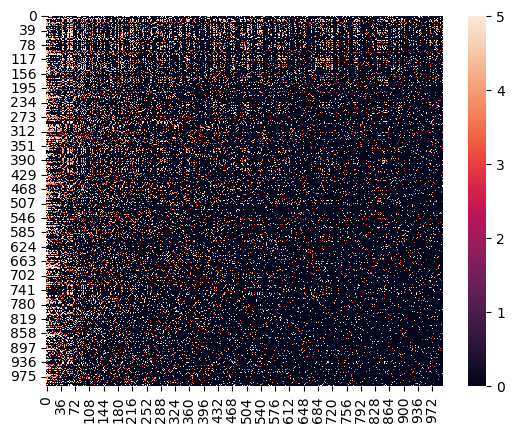

In [8]:
sns.heatmap(matrix_small)

In [9]:
def generate_val_set(y, size=0.1, seed=42, only_observed=True):
    np.random.seed(seed)
    n_users, n_items = y.shape
    n_val = int(size*n_users*n_items)
    y_val = []
    for _ in range(n_val):
        u = np.random.randint(n_users)
        i = np.random.randint(n_items)
        if only_observed:
            while y[u,i] == 0:
                u = np.random.randint(n_users)
                i = np.random.randint(n_items)
        y_val.append((u,i, int(y[u,i])))

    y_train = y.copy()
    for u,i, _ in y_val:
        y_train[u,i] = 0

    return y_train, y_val

In [10]:
Y_train, y_val = generate_val_set(matrix_small, size=0.2, seed=42, only_observed=False)

In [11]:
#np.save('Y_train_books.npy', Y_train)
#np.save('y_val_books.npy', y_val)

In [12]:
Y_train.shape

(1000, 1000)

In [13]:
Y_val_pairs = [(u,i) for u,i,_ in y_val]
Y_val_users = [u for u,_,_ in y_val]
Y_val_items = [i for _,i,_ in y_val]
Y_val_ratings = [r for _,_,r in y_val]

val_users_relevant = {}
val_users_unique = np.unique(Y_val_users)

for u, i in Y_val_pairs:
    if u not in val_users_relevant:
        val_users_relevant[u] = []
    val_users_relevant[u].append(i)

In [14]:
def validate_models(Y_train, Y_val, model_list, param_list, n_iters=500, burn_in=None, verbose=0,
                    thinning=3, model_names=None, true_users=None, true_items=None, k=None, 
                    print_intermid=False):
    
    Y_val_pairs = [(u,i) for u,i,_ in Y_val]
    Y_val_users = [u for u,_,_ in Y_val]
    Y_val_items = [i for _,i,_ in Y_val]
    Y_val_ratings = [r for _,_,r in Y_val]
    
    
    val_users_relevant = {}

    for j in range(len(Y_val_pairs)):
        u = Y_val_users[j]
        i = Y_val_items[j]
        r = Y_val_ratings[j]
        if u not in val_users_relevant:
            val_users_relevant[u] = [] 
        if r > 1:
            val_users_relevant[u].append(i)
    
    val_users_unique = list(val_users_relevant.keys())
    
    model_list_out = []

    for i in range(len(model_list)):
        if model_names is not None:
            name = model_names[i]
        else:
            name = i

        print('\nModel name:', name)

        model_type = model_list[i]
        params = param_list[i]
        model = model_type(Y=Y_train, num_users=Y_train.shape[0], num_items=Y_train.shape[1], **params)
        print('Starting training for model', name)
        llk_model, user_cl_model, item_cl_model = model.gibbs_train(n_iters, verbose=verbose)
        model_est_users, model_est_items, model_vi_users, model_vi_items = model.estimate_cluster_assignment_vi(burn_in=burn_in, thinning=thinning)

        waic_model = None
        llk_edges = []

        #print('Starting waic computation', name)
        #llk_edges = []
        #for iter in range(burn_in, model.n_iters, thinning):
        #    llk_edges.append(model.compute_llk(iter))
        #waic_model = waic_calculation(np.array(llk_edges))

        print('Starting prediction for model', name)
        model_ratings = model.point_predict(Y_val_pairs, seed=42)
        mae_model = mean_absolute_error(Y_val_ratings, model_ratings)
        mse_model = mean_squared_error(Y_val_ratings, model_ratings)

        if print_intermid is True:
            print(f'MAE {name}: {mae_model}')
            print(f'MSE {name}: {mse_model}')

        print('Starting ranking for model', name)
        if k is None:
            ranks_model = model.predict_with_ranking(val_users_unique)
        else:
            ranks_model = model.predict_k(val_users_unique, k=k)

        precision_list_model = []
        recall_list_model = []
        for j in range(len(val_users_unique)):
            precision_list_model.append(compute_precision(val_users_relevant[val_users_unique[j]], ranks_model[j]))
            recall_list_model.append(compute_recall(val_users_relevant[val_users_unique[j]], ranks_model[j]))
        precision_model = sum(precision_list_model)/len(precision_list_model)
        recall_model = sum(recall_list_model)/len(recall_list_model)

        if print_intermid is True:
            print(f'precision {name}: {precision_model}')
            print(f'recall {name}: {recall_model}')

        if true_users is not None:
            vi_users_model = VI(true_users, model.user_clustering)[0]
            model.vi_users = vi_users_model
        if true_items is not None:
            vi_items_model = VI(true_items, model.item_clustering)[0]
            model.vi_items = vi_items_model

        model.precision_ranks = precision_model
        model.recall_ranks = recall_model
        model.mae = mae_model
        model.mse = mse_model
        model.waic = waic_model
        model.llk_edges = llk_edges

        model_list_out.append(model)

    return model_list_out

In [15]:
params_baseline = {'scheme_type':'DP', 'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':1, 'scheme_param':1, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-10, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5], 'device':'cpu'}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['scheme_param'] = 2 # gives me expected value ~10 for items and ~13 for users
params_dp['scheme_type'] = 'DP'

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['scheme_param'] = 5
params_py['sigma'] = 0.3 # gives me expected value ~10 for items and ~13 for users
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['gamma'] = 0.05 # expected value ~10 for items and ~20 for users
params_gn['scheme_type'] = 'GN'

In [16]:
model_list = [esbm, esbm, esbm]
params_list = [params_gn, params_dp, params_py]
model_names = ['GN', 'DP', 'PY']

In [17]:
out_models_dc = validate_models(Y_train, y_val, model_list, params_list, n_iters=1000, burn_in=10, k = 10, verbose=1,
                                 thinning=1, model_names=model_names, print_intermid=True)


Model name: GN
Starting training for model GN
starting log likelihood -629418.3430403039
0 -419622.7666002806
100 -374792.211253648
200 -374079.78217497765
300 -374085.3977555159
400 -373572.1694209638
500 -373575.8298530791
600 -373218.9272455824
700 -373153.9089389138
800 -372888.8437462715
900 -372897.7257724213
end llk:  -372889.8002034244
Starting prediction for model GN
MAE GN: 0.7537438691311004
MSE GN: 1.716042367649901
Starting ranking for model GN
precision GN: 0.3423
recall GN: 0.11783402102697921

Model name: DP
Starting training for model DP
starting log likelihood -629418.3430403039
0 -420212.0298062222


KeyboardInterrupt: 

In [ ]:
model_gn = out_models_dc[0]
model_dp = out_models_dc[1]
model_py = out_models_dc[2]

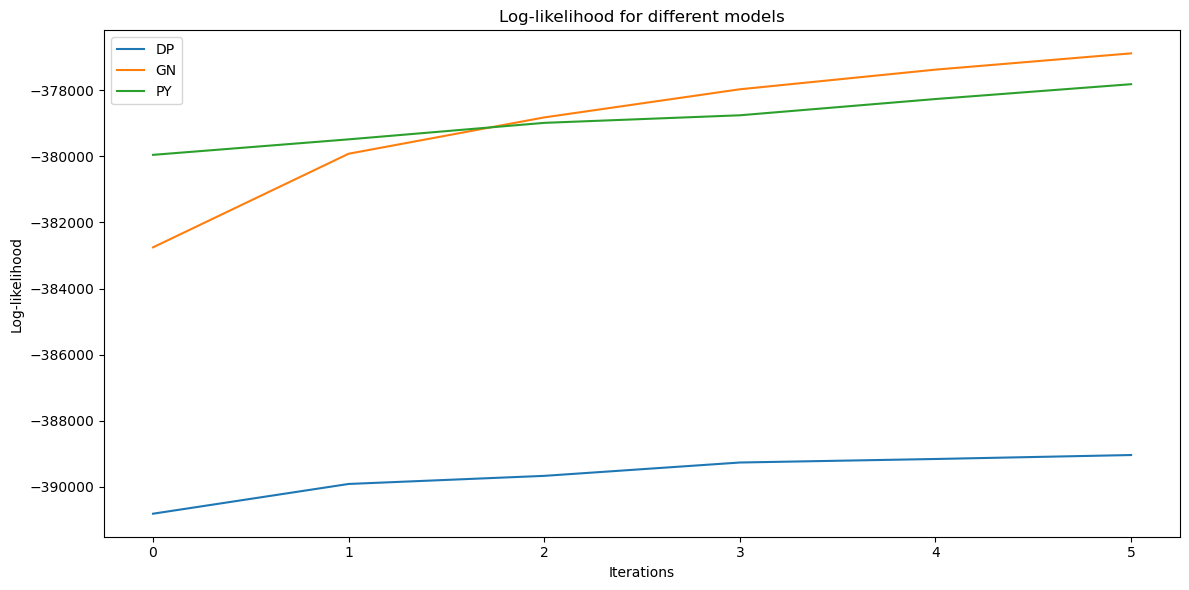

In [ ]:
llk_gn = model_gn.train_llk
llk_dp = model_dp.train_llk
llk_py = model_py.train_llk


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(llk_dp[5:], label='DP')
ax.plot(llk_gn[5:], label='GN')
ax.plot(llk_py[5:], label='PY')

ax.legend()


plt.title('Log-likelihood for different models')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

plt.tight_layout()
plt.show()

In [ ]:
mae_dp = model_dp.mae
mae_py = model_py.mae
mae_gn = model_gn.mae
# mae_esbm = model_esbm.mae

mse_dp = model_dp.mse
mse_py = model_py.mse
mse_gn = model_gn.mse
# mse_esbm = model_esbm.mse

waic_dp = model_dp.waic
waic_py = model_py.waic
waic_gn = model_gn.waic
# waic_esbm = model_esbm.waic

precision_dp = model_dp.precision_ranks
precision_py = model_py.precision_ranks
precision_gn = model_gn.precision_ranks
# precision_esbm = model_esbm.precision_ranks

recall_dp = model_dp.recall_ranks
recall_py = model_py.recall_ranks
recall_gn = model_gn.recall_ranks
# recall_esbm = model_esbm.recall_ranks

output_table = pd.DataFrame()
output_table['MAE'] = [mae_dp, mae_py, mae_gn] 
output_table['MSE'] = [mse_dp, mse_py, mse_gn]
output_table['WAIC'] = [waic_dp, waic_py, waic_gn]
output_table['Precision'] = [precision_dp, precision_py, precision_gn]
output_table['Recall'] = [recall_dp, recall_py, recall_gn]

output_table.index = ['DP', 'PY', 'GN']
output_table

,MAE,MSE,WAIC,Precision,Recall
DP,0.792929,1.821511,None,0.2516,0.092086
PY,0.740046,1.698620,None,0.3203,0.113569
GN,0.684837,1.560585,None,0.3822,0.129958


In [ ]:
model_dp.n_clusters_users, model_dp.n_clusters_items, model_py.n_clusters_users, model_py.n_clusters_items, model_gn.n_clusters_users, model_gn.n_clusters_items, 

(70, 125, 125, 121, 125, 125)

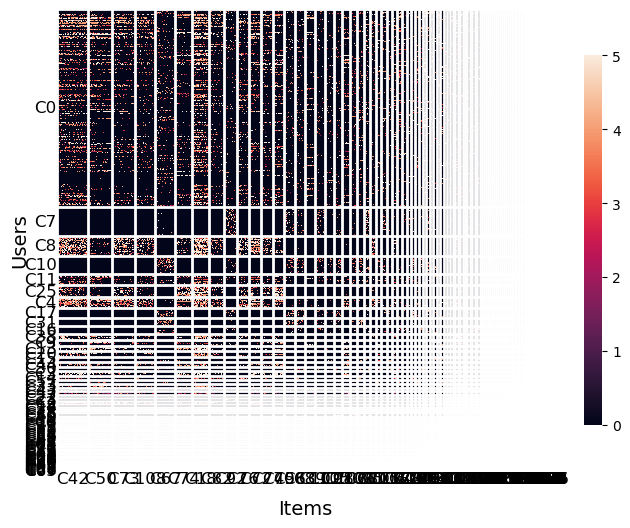

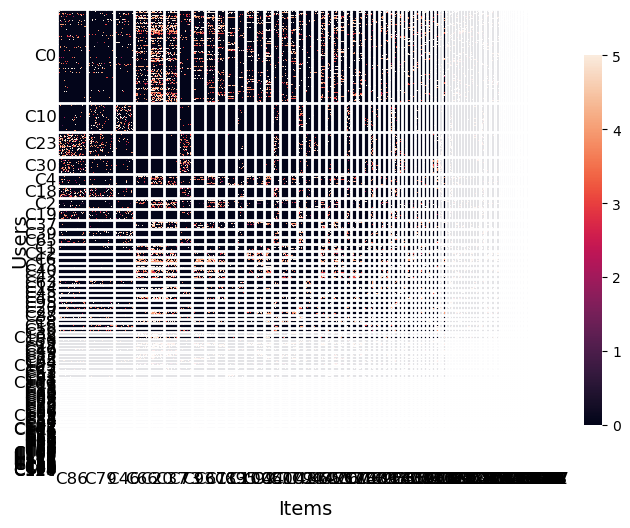

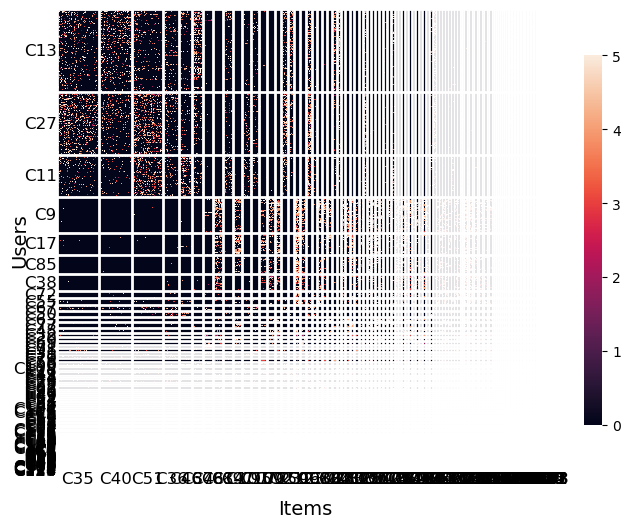

(None, None, None)

In [ ]:
plot_heatmap(model_dp, size=(8,6)), plot_heatmap(model_py, size=(8,6)),plot_heatmap(model_gn, size=(8,6)),

In [ ]:
import pickle

with open('trained_models/model_dp_esbm_onbooks.pkl', 'wb') as f:
    pickle.dump(model_dp, f)

with open('trained_models/model_py_esbm_onbooks.pkl', 'wb') as f:
    pickle.dump(model_py, f)

with open('trained_models/model_gn_esbm_onbooks.pkl', 'wb') as f:
    pickle.dump(model_gn, f)

In [ ]:
plot_heatmap(model_dp)

In [ ]:
plot_heatmap(model_gn)

In [ ]:
plot_heatmap(model_py)